In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
import os

import tensorflow as tf
from keras.layers import Input, Dense, Dropout, BatchNormalization
from keras.models import Model, Sequential
from keras.models import model_from_json

from sklearn.model_selection import train_test_split
from sklearn import metrics

import wandb
from wandb.keras import WandbCallback

#custom packages
from models import createSimpleModel
from animate import *

In [2]:
print(tf.config.list_physical_devices('GPU'))
# Check if tensorflow is using GPU
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Num GPUs Available:  1


Referencing: https://arxiv.org/pdf/2212.11285.pdf

We start off by loading in 1,000,000 background dijet events and 100,000 signal dijet events. The signal comes from the process Z$\rightarrow$ X($\rightarrow$ $q\bar{q}$) Y$\rightarrow$($q\bar{q}$) where Z is 3.5 TeV. X is 500 GeV and Y is 100 GeV. 

In [41]:
dir_path = "/global/cfs/projectdirs/m3246/AnomalyDetection/LHCO/events_anomalydetection.h5"
df_test = pd.read_hdf("/global/cfs/projectdirs/m3246/AnomalyDetection/LHCO/events_anomalydetection.h5")
df_test

,0,1,2,3,4,5,6,7,8,9,...,2091,2092,2093,2094,2095,2096,2097,2098,2099,2100
0,0.324101,-0.361158,2.737669,0.409859,-2.429939,0.729830,0.867922,-2.267777,-1.161310,0.383031,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.646304,-0.539460,-1.386258,0.471293,-1.636572,0.751657,0.453769,-1.099593,-0.393405,0.485929,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.325172,-0.833948,2.404844,1.295058,-2.089618,-1.873342,0.451272,-0.101877,2.217348,0.461293,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.290918,-2.200063,1.630132,0.565028,-1.714345,-2.617103,0.951042,-0.532720,2.941473,0.896248,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.526330,-2.349110,-1.745532,0.542491,-2.080352,-3.044045,0.390727,-1.278563,-2.131058,2.530358,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1099995,0.372368,-1.283898,2.680089,0.511526,-0.216247,1.011824,0.440795,-1.860590,1.395164,1.483386,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1099996,0.587996,-2.347485,0.104980,0.325682,-1.943584,-2.330028,0.700224,-2.161175,0.136797,0.550588,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1099997,0.631419,-0.597308,-2.114541,3.165008,-0.968924,-0.729551,4.613834,-0.989630,-0.724770,3.701483,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1099998,5.084272,-1.004487,1.772670,4.767743,-0.878143,1.713857,10.833469,-0.934815,1.795471,10.265807,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
df_QCD = pd.read_hdf("/global/cfs/projectdirs/m3246/AnomalyDetection/LHCO/events_anomalydetection_DelphesPythia8_v2_qcd_features.h5")

In [14]:
df_QCD

,pxj1,pyj1,pzj1,mj1,tau1j1,tau2j1,tau3j1,pxj2,pyj2,pzj2,mj2,tau1j2,tau2j2,tau3j2
0,-1467.239990,611.502014,511.101990,38.896000,8.290650,4.836080,4.260190,1403.579956,-674.551025,-451.670990,237.893997,79.815102,21.010300,16.757601
1,-1211.239990,347.315002,547.963013,389.532013,191.804001,99.562798,70.872200,619.341003,-62.177299,-1944.040039,22.999201,8.042180,6.335090,5.525370
2,-1229.619995,649.857971,8.089170,72.155502,47.168098,37.243198,33.658199,1196.250000,-647.896973,-1283.109985,78.230698,15.292900,13.944200,10.013500
3,-693.304016,-1046.729980,1716.910034,55.797798,24.788500,6.890140,5.813400,747.961975,994.250000,-412.966003,359.113007,175.209000,103.500999,84.447098
4,-1488.199951,-25.370100,-30.989700,84.891502,26.878799,15.517200,13.260400,1415.640015,20.905100,223.630997,77.506500,57.986000,34.147400,26.660601
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999994,-646.442017,-1295.150024,1331.800049,37.011299,21.006800,12.873700,8.898860,274.566986,1019.390015,-504.290985,90.375000,61.218800,20.514500,15.854600
999995,-286.550995,-1310.829956,-1510.910034,147.516998,60.997799,41.356201,28.225700,252.884995,1085.420044,759.314026,58.769901,42.276402,8.637120,7.852020
999996,918.562988,951.195984,-1622.569946,32.242199,5.894110,5.004100,3.992740,-266.285004,-1284.189941,185.007996,136.389008,70.623901,49.508499,40.708599
999997,1447.219971,-547.710999,827.945007,396.112000,181.406998,152.207993,86.676804,-932.369995,165.005005,-2806.959961,56.471600,14.446400,10.258900,8.874700


In [15]:
df = pd.read_hdf("/global/cfs/projectdirs/m3246/AnomalyDetection/LHCO/events_anomalydetection_DelphesPythia8_v2_Wprime_features.h5")

In [16]:
df

,pxj1,pyj1,pzj1,mj1,tau1j1,tau2j1,tau3j1,pxj2,pyj2,pzj2,mj2,tau1j2,tau2j2,tau3j2
0,-1698.670044,-884.039978,723.843018,105.035004,83.721703,46.282101,13.635700,1539.439941,372.238007,-295.865997,461.574005,431.343994,52.344799,37.284901
1,1246.660034,-1133.010010,-921.987000,159.865997,133.781998,58.968601,30.377399,-1218.489990,1108.380005,182.147003,514.883972,462.654999,138.789001,67.805801
2,420.975006,-1739.790039,281.553986,93.665901,77.925797,10.605900,6.916520,-510.779999,1484.069946,227.175995,475.316986,217.113998,29.424000,21.020300
3,161.048996,-1664.859985,-2005.099976,116.327003,61.819698,38.143600,18.414400,-188.942993,1556.900024,-561.664001,561.236023,348.181000,102.625000,53.422699
4,-564.754028,-1315.599976,-1087.410034,513.015991,276.446991,50.629799,35.460999,326.164001,1050.239990,1201.000000,108.752998,89.666603,40.928699,17.055799
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99994,-206.662003,-1729.280029,357.635010,96.165001,58.014500,11.731300,6.174070,218.800003,1714.890015,-210.578995,472.475006,259.884003,40.806999,31.226000
99995,1069.660034,659.874023,218.751007,126.183998,122.486000,27.608700,17.924801,-956.169006,-297.311005,-2204.350098,108.890999,21.177200,10.582400,9.138590
99996,-1286.619995,-86.162598,-1366.270020,115.719002,109.853996,29.830200,22.489201,1145.729980,136.792007,1216.780029,489.053009,416.747009,84.599998,66.767502
99997,-149.330002,1781.459961,-58.690899,508.045013,495.290985,82.283600,43.567902,84.726601,-1378.569946,-1485.469971,91.104897,79.120102,46.537300,23.227301


Text(0.5, 1.0, 'Jet Mass Distributions')

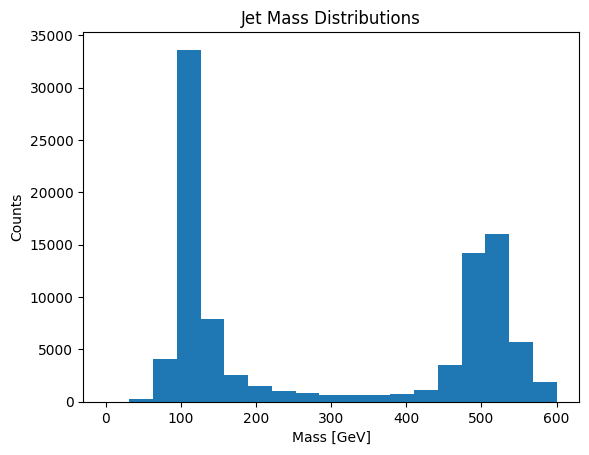

In [65]:
plt.hist(df['mj1'],bins=np.linspace(0,600,20))
plt.xlabel("Mass [GeV]")
plt.ylabel("Counts")
plt.title("Jet Mass Distributions")

In [17]:
df["mj1"]

0        105.035004
1        159.865997
2         93.665901
3        116.327003
4        513.015991
            ...    
99994     96.165001
99995    126.183998
99996    115.719002
99997    508.045013
99998    114.938004
Name: mj1, Length: 99999, dtype: float64

In [3]:
def computemjj_pd(event):
    px1 = event[["pxj1"]].to_numpy()
    py1 = event[["pyj1"]].to_numpy()
    pz1 = event[["pzj1"]].to_numpy()
    pE1 = np.sqrt(px1**2+py1**2+pz1**2+event[["mj1"]].to_numpy()**2)
    
    px2 = event[["pxj2"]].to_numpy()
    py2 = event[["pyj2"]].to_numpy()
    pz2 = event[["pzj2"]].to_numpy()
    pE2 = np.sqrt(px1**2+py1**2+pz1**2+event[["mj2"]].to_numpy()**2)
    
    m2 = (pE1+pE2)**2-(px1+px2)**2-(py1+py2)**2-(pz1+pz2)**2
    return np.array(np.sqrt(m2)).flatten()

In [4]:
def computemjj_txt(event):
    pT1 = np.array([float(event[2*i][0]) for i in range(int(len(event)/2))])
    eta1 = np.array([float(event[2*i][1]) for i in range(int(len(event)/2))])
    phi1 = np.array([float(event[2*i][2]) for i in range(int(len(event)/2))])
    m1 = np.array([float(event[2*i][3]) for i in range(int(len(event)/2))])
    px1 = pT1*np.cos(phi1)
    py1 = pT1*np.sin(phi1)
    pz1 = pT1*np.sinh(eta1)
    pE1 = np.sqrt(px1**2+py1**2+pz1**2+m1**2)
    
    pT2 = np.array([float(event[2*i+1][0]) for i in range(int(len(event)/2))])
    eta2 = np.array([float(event[2*i+1][1]) for i in range(int(len(event)/2))])
    phi2 = np.array([float(event[2*i+1][2]) for i in range(int(len(event)/2))])
    m2 = np.array([float(event[2*i+1][3]) for i in range(int(len(event)/2))])
    px2 = pT2*np.cos(phi2)
    py2 = pT2*np.sin(phi2)
    pz2 = pT2*np.sinh(eta2)
    pE2 = np.sqrt(px2**2+py2**2+pz2**2+m2**2)
    
    m2 = (pE1+pE2)**2-(px1+px2)**2-(py1+py2)**2-(pz1+pz2)**2
    return np.array(np.sqrt(m2)).flatten()

In [5]:
mass_range = [0,0.5,1,1.5,2,2.5,3,3.5,4,4.5,5,5.5,6]
if (False):
    lmass_vec = {}
    x = {}
    mjjs = {}

    mu_m = 0.
    mu_t = 0.
    sd_m = 0.
    sd_t = 0.

    for m1 in mass_range:
        for m2 in mass_range:

            print("on ...",m1,m2)

            ltau1_m_m = []
            ltau2_m_m = []
            stau1_m_m = []
            stau2_m_m = []
            if (m1>0 and m2>0):
                myfile = open("/global/cfs/projectdirs/m3246/AnomalyDetection/ILC/Delphes-3.5.0/LHCO_RnD_qq/LHCO_RnD_qq_"+str(int(m1*100))+"_"+str(int(100*m2))+".txt")
                jets_m_m = []
                for line in myfile:
                    jets_m_m+=[line.split("J")[1].split("P")[0].split()]
                    pass
                                    
                ljet_m_m = [jets_m_m[2*n] for n in range(int(len(jets_m_m)/2))]
                sjet_m_m = [jets_m_m[2*n+1] for n in range(int(len(jets_m_m)/2))]

                lmass_m_m = np.array([float(ljet_m_m[i][3]) for i in range(len(ljet_m_m))])/1000.
                smass_m_m = np.array([float(sjet_m_m[i][3]) for i in range(len(sjet_m_m))])/1000.

                #check ordering of the leading and subleading jets
                #if leading jet mm > subleading, continue
                #if leading jet mm < subleading, swap
                for i in range(int(len(lmass_m_m))):
                    if lmass_m_m[i] > smass_m_m[i]:
                        continue
                    elif lmass_m_m[i] < smass_m_m[i]:
                        lmass_m_m[i], smass_m_m[i] = smass_m_m[i], lmass_m_m[i]
                
                ltau1_m_m = np.array([float(ljet_m_m[i][5]) for i in range(len(ljet_m_m))])
                ltau2_m_m = np.array([float(ljet_m_m[i][6]) for i in range(len(ljet_m_m))])

                stau1_m_m = np.array([float(sjet_m_m[i][5]) for i in range(len(ljet_m_m))])
                stau2_m_m = np.array([float(sjet_m_m[i][6]) for i in range(len(ljet_m_m))])

                mjj = computemjj_txt(jets_m_m)/1000.
                mjjs[m1,m2] = mjj
                passcut = (mjj > 3.3) * (mjj < 3.7)
                lmass_m_m = lmass_m_m[passcut]
                smass_m_m = smass_m_m[passcut]
                ltau1_m_m = ltau1_m_m[passcut]
                ltau2_m_m = ltau2_m_m[passcut]
                stau1_m_m = stau1_m_m[passcut]
                stau2_m_m = stau2_m_m[passcut]
                pass
            elif m1==0 and m2==0:
                df_QCD = pd.read_hdf("/global/cfs/projectdirs/m3246/AnomalyDetection/LHCO/events_anomalydetection_DelphesPythia8_v2_qcd_features.h5")
                lmass_m_m = np.array(df_QCD[["mj1"]]).flatten()/1000.
                smass_m_m = np.array(df_QCD[["mj2"]]).flatten()/1000.
                
                #check jet ordering
                for i in range(int(len(lmass_m_m))):
                    if lmass_m_m[i] > smass_m_m[i]:
                        continue
                    elif lmass_m_m[i] < smass_m_m[i]:
                        lmass_m_m[i], smass_m_m[i] = smass_m_m[i], lmass_m_m[i]
                        
                ltau1_m_m = np.array(df_QCD[["tau1j1"]]).flatten()
                ltau2_m_m = np.array(df_QCD[["tau2j1"]]).flatten()
                stau1_m_m = np.array(df_QCD[["tau1j2"]]).flatten()
                stau2_m_m = np.array(df_QCD[["tau2j2"]]).flatten()
                mjj = computemjj_pd(df_QCD)/1000.
                mjjs[m1,m2] = mjj
                passcut = (mjj > 3.3) * (mjj < 3.7)
                lmass_m_m = lmass_m_m[passcut]
                smass_m_m = smass_m_m[passcut]
                ltau1_m_m = ltau1_m_m[passcut]
                ltau2_m_m = ltau2_m_m[passcut]
                stau1_m_m = stau1_m_m[passcut]
                stau2_m_m = stau2_m_m[passcut]

                mu_m = np.mean(lmass_m_m)
                mu_t = np.mean(ltau2_m_m/(ltau1_m_m+0.0001))
                sd_m = np.std(lmass_m_m)
                sd_t = np.std(ltau2_m_m/(ltau1_m_m+0.0001))
                pass
            else:
                continue

            ms = np.stack([lmass_m_m,smass_m_m],axis=1)
            ts = np.stack([ltau2_m_m/(ltau1_m_m+0.0001),stau2_m_m/(stau1_m_m+0.001)],axis=1)
            order1 = [np.argmax(ms[i]) for i in range(len(ms))]
            order2 = [np.argmin(ms[i]) for i in range(len(ms))]
            mJ1 = np.array([ms[i][order1[i]] for i in range(len(ms))])
            mJ2 = np.array([ms[i][order2[i]] for i in range(len(ms))])
            x[m1,m2] = np.stack([(mJ2 - mu_m)/sd_m,
                                    ((mJ1 - mJ2) - mu_m)/sd_m,
                                    ([ts[i][order2[i]] for i in range(len(ts))] - mu_t)/sd_t,
                                    ([ts[i][order1[i]] for i in range(len(ts))] - mu_t)/sd_t],axis=1)
            lmass_vec[m1,m2]=lmass_m_m
            pass
        pass

    x_array = []
    for m1 in mass_range:
        for m2 in mass_range:
            if (m1==0 and m2>0 or m2==0 and m1>0):
                continue
            x_array+=[x[m1,m2]]
    np.save("x_array_order", x_array)

In [46]:
myfile = open("/global/cfs/projectdirs/m3246/AnomalyDetection/ILC/Delphes-3.5.0/LHCO_RnD_qq/LHCO_RnD_qq_"+str(int(m1*100))+"_"+str(int(100*m2))+".txt")
jets_m_m = []

count=0
for line in myfile:
    if count == -1:
        break
    jets_m_m+=[line.split("J")[1].split("P")[0].split()]
    count+=1
    #print(line)

ljet_m_m = [jets_m_m[2*n] for n in range(int(len(jets_m_m)/2))]
sjet_m_m = [jets_m_m[2*n+1] for n in range(int(len(jets_m_m)/2))]

lmass_m_m = np.array([float(ljet_m_m[i][3]) for i in range(len(ljet_m_m))])/1000.
smass_m_m = np.array([float(sjet_m_m[i][3]) for i in range(len(sjet_m_m))])/1000.

In [53]:
lmass_m_m

array([0.100014, 0.612078, 0.583052, ..., 0.622225, 0.681239, 0.161697])

In [59]:
df_QCD = pd.read_hdf("/global/cfs/projectdirs/m3246/AnomalyDetection/LHCO/events_anomalydetection_DelphesPythia8_v2_qcd_features.h5")
lmass_m_m = np.array(df_QCD[["mj1"]]).flatten()/1000.
smass_m_m = np.array(df_QCD[["mj2"]]).flatten()/1000.

In [28]:
# #reads in data 
# x = {}
# x_array_read = np.load("/global/cfs/projectdirs/m3246/AnomalyDetection/LHCO/x_vals_qq.npy",allow_pickle=True)
# mycounter = -1
# for m1 in mass_range:
#     for m2 in mass_range:
#         if (m1==0 and m2>0 or m2==0 and m1>0):
#             continue
#         mycounter+=1
#         x[m1,m2] = x_array_read[mycounter]

In [9]:
# x = {}
# x_array_read = np.load("/global/cfs/projectdirs/m3246/AnomalyDetection/LHCO/x_array.npy",allow_pickle=True)
# mycounter = -1
# for m1 in [0,0.5,1,1.5,2,2.5,3,3.5,4,4.5,5,5.5,6]:
#     for m2 in [0,0.5,1,1.5,2,2.5,3,3.5,4,4.5,5,5.5,6]:
#         if (m1==0 and m2>0 or m2==0 and m1>0):
#             continue
#         mycounter+=1
#         x[m1,m2] = x_array_read[mycounter]

In [3]:
x = {}
x_array_read = np.load("x_array_order.npy",allow_pickle=True)
mycounter = -1
for m1 in [0,0.5,1,1.5,2,2.5,3,3.5,4,4.5,5,5.5,6]:
    for m2 in [0,0.5,1,1.5,2,2.5,3,3.5,4,4.5,5,5.5,6]:
        if (m1==0 and m2>0 or m2==0 and m1>0):
            continue
        mycounter+=1
        x[m1,m2] = x_array_read[mycounter]

In [4]:
np.shape(x[0,0])

(120930, 4)

In [28]:
x_vals_100 = np.concatenate([x[0,0],x[1,1]])
y_vals_100 = np.concatenate([np.zeros(len(x[0,0])),np.ones(len(x[1,1]))])
X_train_100, X_val_100, Y_train_100, Y_val_100 = train_test_split(x_vals_100, y_vals_100, test_size=0.5)
X_val_100, X_test_100, Y_val_100, Y_test_100 = train_test_split(X_val_100, Y_val_100, test_size=0.5)

In [36]:
pscratch_dir = "/pscratch/sd/g/gupsingh"
os.environ["WANDB_DIR"] = pscratch_dir

wandb.init(
    project="Anomaly",
    group="Dedicated_Orderd",
    entity='gup-singh',
    mode = 'online',

    config={
        "layer_1": 256,
        "activation_1": "relu",
        "layer_2": 128,
        "activation_2": "relu",
        "layer_3": 64,
        "activation_3": "relu",
        "output_layer": 1,
        "output_activation": "sigmoid",
        "optimizer": "adam",
        "loss": "binary_crossentropy",
        "metric": "accuracy",
        "epoch": 1000,
        "batch_size": 1024,
    },
    dir=pscratch_dir
)

config = wandb.config

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


accuracy,▁▂▃▃▄▄▄▄▄▄▅▄▅▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇█▇███
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▇▆▆▆▆▆▅▅▅▅▅▅▅▅▅▄▄▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁
val_accuracy,▁▂▂▃▃▄▄▃▄▂▄▅▄▅▄▅▅▄▅▅▅▆▅▅▆▆▆▆▇▆▇▇▇▇▇▇▇▇▇█
val_loss,█▇▇▆▆▆▆▆▆▆▅▅▅▅▅▅▅▄▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁
accuracy,0.92456
best_epoch,448
best_val_loss,0.17267
epoch,459
loss,0.17375
val_accuracy,0.9246


In [43]:
model_dedicated = Sequential()
model_dedicated.add(Dense(config.layer_1, input_dim=4, activation=config.activation_1))
#model_dedicated.add(Dropout(config.dropout_rate_1))
model_dedicated.add(Dense(config.layer_2, activation=config.activation_2))
model_dedicated.add(Dense(config.layer_3, activation=config.activation_3))
model_dedicated.add(Dense(config.output_layer, activation=config.output_activation))
model_dedicated.compile(loss=config.loss, optimizer=config.optimizer, metrics=[config.metric])
model_dedicated.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_20 (Dense)            (None, 256)               1280      
                                                                 
 dense_21 (Dense)            (None, 128)               32896     
                                                                 
 dense_22 (Dense)            (None, 64)                8256      
                                                                 
 dense_23 (Dense)            (None, 1)                 65        
                                                                 
Total params: 42,497
Trainable params: 42,497
Non-trainable params: 0
_________________________________________________________________


In [44]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

In [45]:
myhistory = model_dedicated.fit(X_train_100, Y_train_100, epochs=config.epoch, validation_data=(X_val_100, Y_val_100),batch_size=config.batch_size, callbacks=[WandbCallback(), es])

Epoch 1/1000
97/97 [==============================] - 1s 4ms/step - loss: 0.3373 - accuracy: 0.8570 - val_loss: 0.2664 - val_accuracy: 0.8924
Epoch 2/1000
97/97 [==============================] - 0s 3ms/step - loss: 0.2526 - accuracy: 0.8967 - val_loss: 0.2394 - val_accuracy: 0.9029
Epoch 3/1000
97/97 [==============================] - 0s 3ms/step - loss: 0.2326 - accuracy: 0.9048 - val_loss: 0.2305 - val_accuracy: 0.9054
Epoch 4/1000
97/97 [==============================] - 0s 3ms/step - loss: 0.2143 - accuracy: 0.9119 - val_loss: 0.2039 - val_accuracy: 0.9148
Epoch 5/1000
97/97 [==============================] - 0s 3ms/step - loss: 0.2018 - accuracy: 0.9157 - val_loss: 0.2104 - val_accuracy: 0.9132
Epoch 6/1000
97/97 [==============================] - 0s 3ms/step - loss: 0.1983 - accuracy: 0.9176 - val_loss: 0.1936 - val_accuracy: 0.9193
Epoch 7/1000
97/97 [==============================] - 0s 3ms/step - loss: 0.1969 - accuracy: 0.9179 - val_loss: 0.1950 - val_accuracy: 0.9184
Epoch 

wandb: Adding directory to artifact (/pscratch/sd/g/gupsingh/wandb/run-20231116_124525-y4lnvet1/files/model-best)... Done. 0.0s


97/97 [==============================] - 1s 9ms/step - loss: 0.1922 - accuracy: 0.9189 - val_loss: 0.1904 - val_accuracy: 0.9211
Epoch 37/1000
97/97 [==============================] - 0s 3ms/step - loss: 0.1925 - accuracy: 0.9188 - val_loss: 0.1917 - val_accuracy: 0.9206
Epoch 38/1000
97/97 [==============================] - 0s 2ms/step - loss: 0.1932 - accuracy: 0.9182 - val_loss: 0.1917 - val_accuracy: 0.9207
Epoch 39/1000
97/97 [==============================] - 0s 3ms/step - loss: 0.1924 - accuracy: 0.9194 - val_loss: 0.1916 - val_accuracy: 0.9201
Epoch 40/1000
97/97 [==============================] - 0s 2ms/step - loss: 0.1924 - accuracy: 0.9192 - val_loss: 0.1942 - val_accuracy: 0.9200
Epoch 41/1000
97/97 [==============================] - 0s 2ms/step - loss: 0.1925 - accuracy: 0.9189 - val_loss: 0.1914 - val_accuracy: 0.9207
Epoch 42/1000
73/97 [=====================>........] - ETA: 0s - loss: 0.1916 - accuracy: 0.9190

wandb: WARNING Failed to cache /global/homes/g/gupsingh/.local/share/wandb/artifacts/staging/tmpie88f098, ignoring [Errno 2] No such file or directory: '/global/homes/g/gupsingh/.cache/wandb/artifacts'
wandb: WARNING Failed to cache /global/homes/g/gupsingh/.local/share/wandb/artifacts/staging/tmpufli1p2h, ignoring [Errno 2] No such file or directory: '/global/homes/g/gupsingh/.cache/wandb/artifacts'
wandb: WARNING Failed to cache /global/homes/g/gupsingh/.local/share/wandb/artifacts/staging/tmp1y2yel1i, ignoring [Errno 2] No such file or directory: '/global/homes/g/gupsingh/.cache/wandb/artifacts'
wandb: WARNING Failed to cache /global/homes/g/gupsingh/.local/share/wandb/artifacts/staging/tmptnx4v6qe, ignoring [Errno 2] No such file or directory: '/global/homes/g/gupsingh/.cache/wandb/artifacts'


97/97 [==============================] - 0s 2ms/step - loss: 0.1923 - accuracy: 0.9188 - val_loss: 0.1929 - val_accuracy: 0.9202
Epoch 43/1000
97/97 [==============================] - 0s 2ms/step - loss: 0.1917 - accuracy: 0.9191 - val_loss: 0.1914 - val_accuracy: 0.9199
Epoch 44/1000
97/97 [==============================] - 0s 2ms/step - loss: 0.1925 - accuracy: 0.9191 - val_loss: 0.1981 - val_accuracy: 0.9166
Epoch 45/1000
97/97 [==============================] - 0s 3ms/step - loss: 0.1924 - accuracy: 0.9193 - val_loss: 0.1923 - val_accuracy: 0.9192
Epoch 46/1000
97/97 [==============================] - 0s 2ms/step - loss: 0.1925 - accuracy: 0.9192 - val_loss: 0.1919 - val_accuracy: 0.9206


In [47]:
wandb.finish()

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


accuracy,▁▅▅▅▅▆▅▆▆▆▆▆▆▆▇▆▆▆▇▆▇▇▇▇▇▇▇▇▇█▇█████▅▅▅▅
epoch,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███▁▁▁▂
loss,█▄▄▄▄▄▃▃▃▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▄▄▄▄
val_accuracy,▁▅▇▆▇▆▆▇▇▇▆▇█▇▇███▇▇▇▆▆▇▇▇▆▆▄▅▆▅▆▄▅▅▄▅▇▆
val_loss,▅▂▁▂▁▁▁▁▁▁▂▁▂▂▂▂▂▂▃▂▃▄▃▃▃▄▄▄▅▅▅▅▅▆▇█▂▂▁▁
accuracy,0.91918
best_epoch,35
best_val_loss,0.19039
epoch,45
loss,0.19245
val_accuracy,0.92058


In [7]:
model_dedicated = Sequential()
model_dedicated.add(Dense(128, input_dim=4, activation='relu'))
model_dedicated.add(Dense(128, activation='relu'))
model_dedicated.add(Dense(128, activation='relu'))
model_dedicated.add(Dense(1, activation='sigmoid'))
model_dedicated.compile(loss="binary_crossentropy", optimizer='adam', metrics=['accuracy'])

2023-11-15 14:26:47.851303: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-15 14:26:48.528032: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 12293 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:c3:00.0, compute capability: 8.0


In [9]:
myhistory = model_dedicated.fit(X_train_100, Y_train_100, epochs=100,validation_data=(X_val_100, Y_val_100),batch_size=1024)

Epoch 1/100
193/193 [==============================] - 0s 2ms/step - loss: 0.1931 - accuracy: 0.9190 - val_loss: 0.1905 - val_accuracy: 0.9201
Epoch 2/100
193/193 [==============================] - 0s 2ms/step - loss: 0.1921 - accuracy: 0.9194 - val_loss: 0.1890 - val_accuracy: 0.9206
Epoch 3/100
193/193 [==============================] - 0s 2ms/step - loss: 0.1920 - accuracy: 0.9198 - val_loss: 0.1891 - val_accuracy: 0.9208
Epoch 4/100
193/193 [==============================] - 0s 2ms/step - loss: 0.1929 - accuracy: 0.9191 - val_loss: 0.1888 - val_accuracy: 0.9213
Epoch 5/100
193/193 [==============================] - 0s 2ms/step - loss: 0.1918 - accuracy: 0.9199 - val_loss: 0.1884 - val_accuracy: 0.9211
Epoch 6/100
193/193 [==============================] - 0s 2ms/step - loss: 0.1925 - accuracy: 0.9190 - val_loss: 0.1893 - val_accuracy: 0.9207
Epoch 7/100
193/193 [==============================] - 0s 2ms/step - loss: 0.1919 - accuracy: 0.9195 - val_loss: 0.1883 - val_accuracy: 0.9206

In [34]:
wandb.finish()

In [100]:
#model_dedicated.save("model_100_MSE_3_4096")
#model.save("model_MSE")

INFO:tensorflow:Assets written to: model_100_MSE_3_4096/assets


In [59]:
preds_mm_list = []

tuple_rates_dedicated_ordered_BCE_Optimized = {}

for i in mass_range[1:]:
    for j in mass_range[1:]:
        if (i == 0.5 and j == 0.5) or (i == 1 and j == 1) or (i == 3 and j == 3) or (i == 6 and j == 6):
            print(i,j)
            x_vals_mm = np.concatenate([x[0,0],x[i,j]])
            y_vals_mm = np.concatenate([np.zeros(len(x[0,0])),np.ones(len(x[i,j]))])
            X_train_mm, X_val_mm, Y_train_mm, Y_val_mm = train_test_split(x_vals_mm, y_vals_mm, test_size=0.5)

            model = Sequential()
            model.add(Dense(128, input_dim=4, activation='relu'))
            model.add(Dense(128, activation='relu'))
            model.add(Dense(128, activation='relu'))
            model.add(Dense(1, activation='sigmoid'))
            model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

            myhistory = model.fit(X_train_mm, Y_train_mm, epochs=1000, validation_data=(X_val_mm, Y_val_mm),batch_size=1024, callbacks = [es])

            preds_mm = model.predict(X_val_mm,batch_size=1000)
            fpr_mm, tpr_mm, _ = metrics.roc_curve(Y_val_mm, preds_mm)

            preds_mm_list.append(preds_mm)
            tuple_rates_dedicated_BCE_Optimized[tuple((i, j))] = [fpr_mm, tpr_mm]

0.5 0.5
Epoch 1/1000
192/192 [==============================] - 2s 6ms/step - loss: 0.2920 - accuracy: 0.8740 - val_loss: 0.2710 - val_accuracy: 0.8852
Epoch 2/1000
192/192 [==============================] - 1s 5ms/step - loss: 0.2666 - accuracy: 0.8874 - val_loss: 0.2613 - val_accuracy: 0.8931
Epoch 3/1000
192/192 [==============================] - 1s 5ms/step - loss: 0.2588 - accuracy: 0.8922 - val_loss: 0.2572 - val_accuracy: 0.8919
Epoch 4/1000
192/192 [==============================] - 1s 5ms/step - loss: 0.2567 - accuracy: 0.8930 - val_loss: 0.2545 - val_accuracy: 0.8939
Epoch 5/1000
192/192 [==============================] - 1s 6ms/step - loss: 0.2557 - accuracy: 0.8927 - val_loss: 0.2544 - val_accuracy: 0.8944
Epoch 6/1000
192/192 [==============================] - 1s 5ms/step - loss: 0.2555 - accuracy: 0.8927 - val_loss: 0.2522 - val_accuracy: 0.8950
Epoch 7/1000
192/192 [==============================] - 1s 5ms/step - loss: 0.2553 - accuracy: 0.8933 - val_loss: 0.2530 - val_a

In [60]:
len(tuple_rates_dedicated_BCE_Optimized)

4

In [61]:
# np.save("fpr_mm", fpr_mm_list)
# np.save("tpr_mm", tpr_mm_list)
np.save("tuple_rates_dedicated_BCE_Optimized_3_4096", tuple_rates_dedicated_BCE_Optimized)

#fpr_mm_list = np.load("fpr_mm.npy", allow_pickle = True)

In [62]:
model_all_BCE = tf.keras.models.load_model('model_all_BCE')

In [114]:
tuple_rates_dedicated = np.load("tuple_rates_dedicated.npy", allow_pickle = True).item()
len(tuple_rates_dedicated)

144

In [65]:
preds_all_BCE_50 = model_all_BCE.predict(X_val_all[np.product(X_val_all[:,4:6]==[0.5,0.5],axis=1)==1],batch_size=1000)
fpr_all_BCE_50, tpr_all_BCE_50, _ = metrics.roc_curve(Y_val_all[np.product(X_val_all[:,4:6]==[0.5,0.5],axis=1)==1], preds_all_BCE_50)

99/99 [==============================] - 0s 756us/step


91/91 [==============================] - 0s 2ms/step


/tmp/ipykernel_46945/334003819.py:6: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr_all_BCE_50, 1/fpr_all_BCE_50, label = str(m))


91/91 [==============================] - 0s 2ms/step


/tmp/ipykernel_46945/334003819.py:6: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr_all_BCE_50, 1/fpr_all_BCE_50, label = str(m))


91/91 [==============================] - 0s 2ms/step


/tmp/ipykernel_46945/334003819.py:6: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr_all_BCE_50, 1/fpr_all_BCE_50, label = str(m))


91/91 [==============================] - 0s 2ms/step


/tmp/ipykernel_46945/334003819.py:6: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr_all_BCE_50, 1/fpr_all_BCE_50, label = str(m))


91/91 [==============================] - 0s 2ms/step


/tmp/ipykernel_46945/334003819.py:6: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr_all_BCE_50, 1/fpr_all_BCE_50, label = str(m))


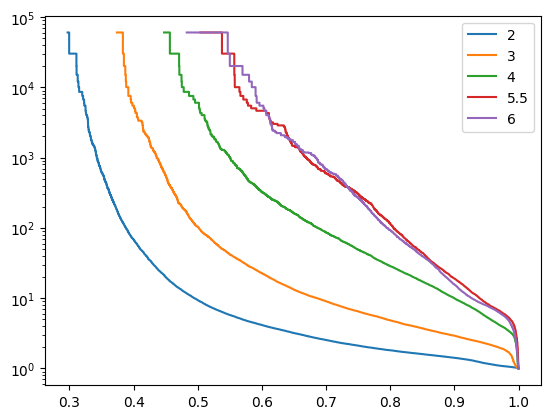

In [181]:
for m in [2, 3, 4, 5.5, 6]:
    something = X_val_all[np.product(X_val_all[:,4:6]==[4.5,6],axis=1)==1]
    something[:,4:6]= np.c_[np.ones(len(something)) * m, np.ones(len(something)) * m]
    preds_all_BCE_50 = model_all_BCE.predict(something,batch_size=1000)
    fpr_all_BCE_50, tpr_all_BCE_50, _ = metrics.roc_curve(Y_val_all[np.product(X_val_all[:,4:6]==[4.5,6],axis=1)==1], preds_all_BCE_50)
    plt.plot(tpr_all_BCE_50, 1/fpr_all_BCE_50, label = str(m))
    plt.legend()
    plt.yscale("log")

In [174]:
np.shape(np.c_[np.ones(len(something)) * 3, np.ones(len(something)) * 3])

(98560, 2)

In [172]:
np.shape(something[:,4:6])

(98560, 2)

In [63]:
preds_all_BCE_100 = model_all_BCE.predict(X_val_all[np.product(X_val_all[:,4:6]==[1,1],axis=1)==1],batch_size=1000)
fpr_all_BCE_100, tpr_all_BCE_100, _ = metrics.roc_curve(Y_val_all[np.product(X_val_all[:,4:6]==[1,1],axis=1)==1], preds_all_BCE_100)

preds_all_BCE_200 = model_all_BCE.predict(X_val_all[np.product(X_val_all[:,4:6]==[2,2],axis=1)==1],batch_size=1000)
fpr_all_BCE_200, tpr_all_BCE_200, _ = metrics.roc_curve(Y_val_all[np.product(X_val_all[:,4:6]==[2,2],axis=1)==1], preds_all_BCE_200)

preds_all_BCE_300 = model_all_BCE.predict(X_val_all[np.product(X_val_all[:,4:6]==[3,3],axis=1)==1],batch_size=1000)
fpr_all_BCE_300, tpr_all_BCE_300, _ = metrics.roc_curve(Y_val_all[np.product(X_val_all[:,4:6]==[3,3],axis=1)==1], preds_all_BCE_300)

preds_all_BCE_400 = model_all_BCE.predict(X_val_all[np.product(X_val_all[:,4:6]==[4,4],axis=1)==1],batch_size=1000)
fpr_all_BCE_400, tpr_all_BCE_400, _ = metrics.roc_curve(Y_val_all[np.product(X_val_all[:,4:6]==[4,4],axis=1)==1], preds_all_BCE_400)

preds_all_BCE_500 = model_all_BCE.predict(X_val_all[np.product(X_val_all[:,4:6]==[5,5],axis=1)==1],batch_size=1000)
fpr_all_BCE_500, tpr_all_BCE_500, _ = metrics.roc_curve(Y_val_all[np.product(X_val_all[:,4:6]==[5,5],axis=1)==1], preds_all_BCE_500)

preds_all_BCE_600 = model_all_BCE.predict(X_val_all[np.product(X_val_all[:,4:6]==[6,6],axis=1)==1],batch_size=1000)
fpr_all_BCE_600, tpr_all_BCE_600, _ = metrics.roc_curve(Y_val_all[np.product(X_val_all[:,4:6]==[6,6],axis=1)==1], preds_all_BCE_600)

87/87 [==============================] - 0s 757us/step


In [64]:
tuple_rates_dedicated_BCE_Optimized.keys()

dict_keys([(0.5, 0.5), (1, 1), (3, 3), (6, 6)])

Text(0.5, 1.0, '$(600,600)$ GeV Dedicated vs Parametrized BCE')

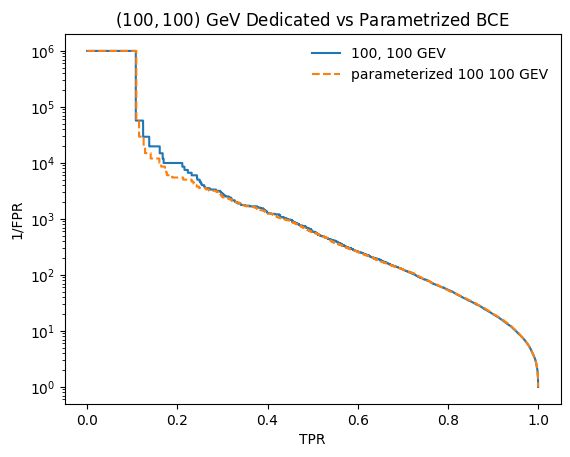

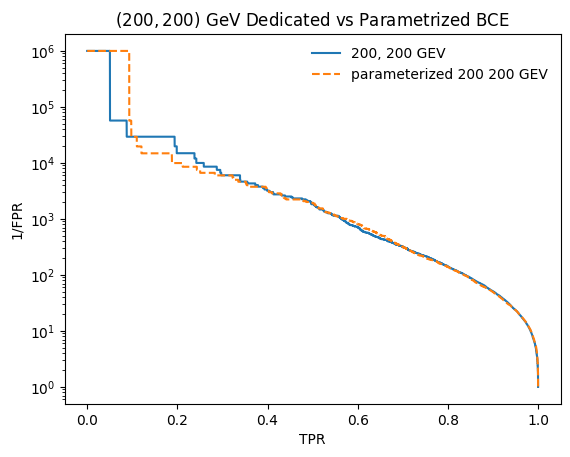

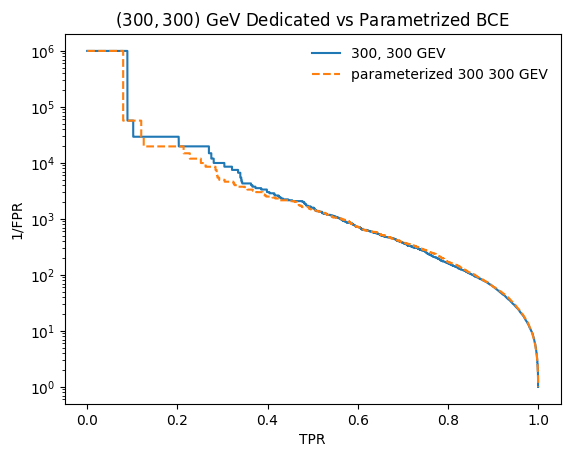

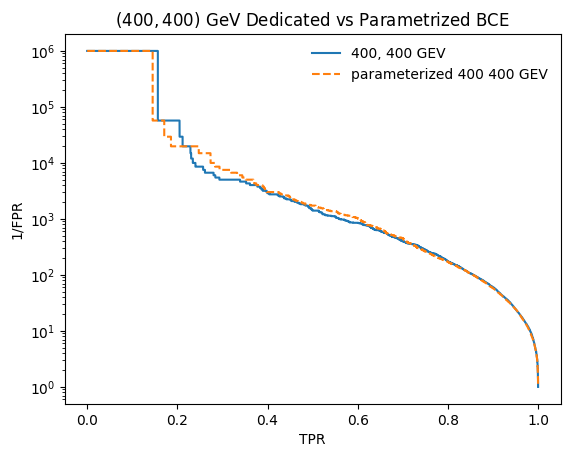

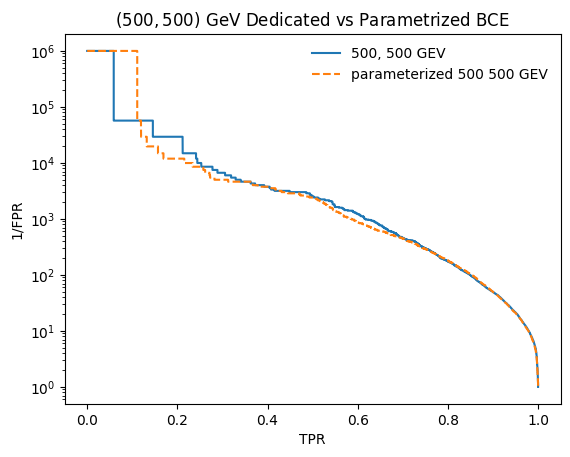

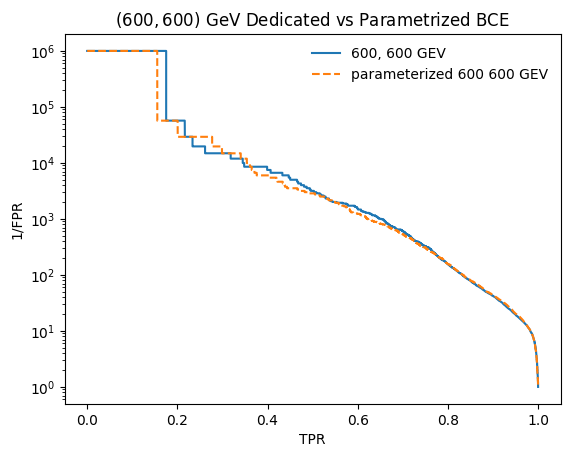

In [116]:
epsilon = 1e-6
plt.figure()
plt.plot(tuple_rates_dedicated[(1,1)][1], 1./(tuple_rates_dedicated[(1,1)][0] + epsilon), label = "100, 100 GEV")
plt.plot(tpr_all_BCE_100, 1./(fpr_all_BCE_100 + epsilon),label="parameterized 100 100 GEV", linestyle='dashed')
plt.yscale("log")
plt.legend(frameon=False)
plt.xlabel("TPR")
plt.ylabel("1/FPR")
plt.title("$(100,100)$ GeV Dedicated vs Parametrized BCE")

plt.figure()
plt.plot(tuple_rates_dedicated[(2,2)][1], 1./(tuple_rates_dedicated[(2,2)][0] + epsilon), label = "200, 200 GEV")
plt.plot(tpr_all_BCE_200, 1./(fpr_all_BCE_200 + epsilon),label="parameterized 200 200 GEV", linestyle='dashed')
plt.yscale("log")
plt.legend(frameon=False)
plt.xlabel("TPR")
plt.ylabel("1/FPR")
plt.title("$(200,200)$ GeV Dedicated vs Parametrized BCE")

plt.figure()
plt.plot(tuple_rates_dedicated[(3,3)][1], 1./(tuple_rates_dedicated[(3,3)][0] + epsilon), label = "300, 300 GEV")
plt.plot(tpr_all_BCE_300, 1./(fpr_all_BCE_300 + epsilon),label="parameterized 300 300 GEV", linestyle='dashed')
plt.yscale("log")
plt.legend(frameon=False)
plt.xlabel("TPR")
plt.ylabel("1/FPR")
plt.title("$(300,300)$ GeV Dedicated vs Parametrized BCE")

plt.figure()
plt.plot(tuple_rates_dedicated[(4,4)][1], 1./(tuple_rates_dedicated[(4,4)][0] + epsilon), label = "400, 400 GEV")
plt.plot(tpr_all_BCE_400, 1./(fpr_all_BCE_400 + epsilon),label="parameterized 400 400 GEV", linestyle='dashed')
plt.yscale("log")
plt.legend(frameon=False)
plt.xlabel("TPR")
plt.ylabel("1/FPR")
plt.title("$(400,400)$ GeV Dedicated vs Parametrized BCE")

plt.figure()
plt.plot(tuple_rates_dedicated[(5,5)][1], 1./(tuple_rates_dedicated[(5,5)][0] + epsilon), label = "500, 500 GEV")
plt.plot(tpr_all_BCE_500, 1./(fpr_all_BCE_500 + epsilon),label="parameterized 500 500 GEV", linestyle='dashed')
plt.yscale("log")
plt.legend(frameon=False)
plt.xlabel("TPR")
plt.ylabel("1/FPR")
plt.title("$(500,500)$ GeV Dedicated vs Parametrized BCE")

plt.figure()
plt.plot(tuple_rates_dedicated[(6,6)][1], 1./(tuple_rates_dedicated[(6,6)][0] + epsilon), label = "600, 600 GEV")
plt.plot(tpr_all_BCE_600, 1./(fpr_all_BCE_600 + epsilon),label="parameterized 600 600 GEV", linestyle='dashed')
plt.yscale("log")
plt.legend(frameon=False)
plt.xlabel("TPR")
plt.ylabel("1/FPR")
plt.title("$(600,600)$ GeV Dedicated vs Parametrized BCE")

Analysis of Models begins here

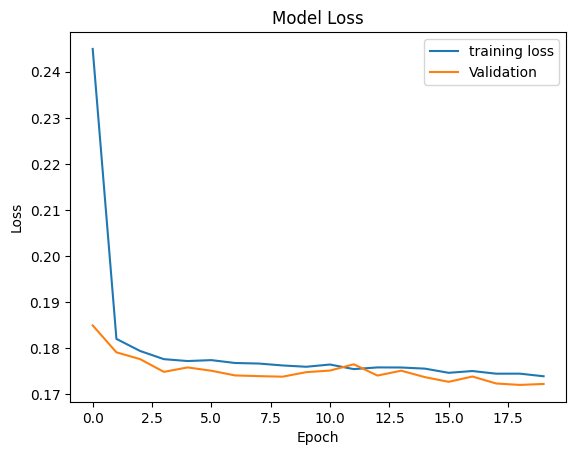

In [255]:
# Plot the training and validation loss
plt.plot(myhistory.history['loss'])
plt.plot(myhistory.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['training loss', 'Validation'], loc='upper right')
plt.show()

In [89]:
preds_100 = model.predict(X_val_100,batch_size=1000)
fpr_100, tpr_100, _ = metrics.roc_curve(Y_val_100, preds_100)

99/99 [==============================] - 0s 737us/step


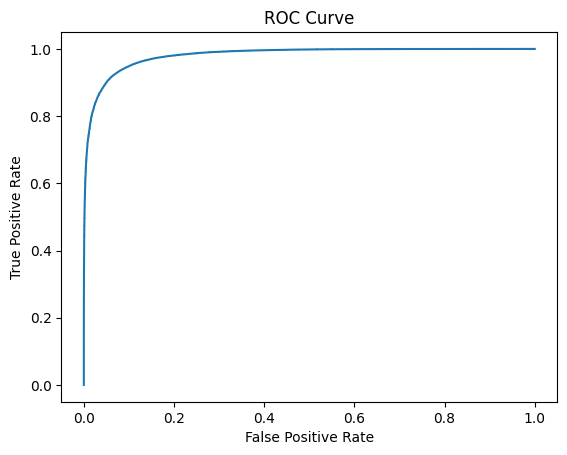

In [79]:
plt.plot(1-tpr_100, 1-fpr_100)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

In [10]:
if (False):
    x_vals_all = []
    y_vals_all = []
    for m1 in [0.5,1,1.5,2,2.5,3,3.5,4,4.5,5,5.5,6]:
        for m2 in [0.5,1,1.5,2,2.5,3,3.5,4,4.5,5,5.5,6]:
            print(m1,m2)
            x_aug_0 = np.append(np.append(x[0,0],m1*np.reshape(np.ones(len(x[0,0])),[len(x[0,0]),1]),1),m2*np.reshape(np.ones(len(x[0,0])),[len(x[0,0]),1]),1)
            x_aug_m = np.append(np.append(x[m1,m2],m1*np.reshape(np.ones(len(x[m1,m2])),[len(x[m1,m2]),1]),1),m2*np.reshape(np.ones(len(x[m1,m2])),[len(x[m1,m2]),1]),1)
            if (m1==0.5 and m2==0.5):
                x_vals_all = np.concatenate([x_aug_0,x_aug_m])
                y_vals_all = np.concatenate([np.zeros(len(x_aug_0)),np.ones(len(x_aug_m))])
            else:
                x_vals_all = np.concatenate([x_vals_all,x_aug_0,x_aug_m])
                y_vals_all = np.concatenate([y_vals_all,np.zeros(len(x_aug_0)),np.ones(len(x_aug_m))])
    np.save("x_vals_all_ordered",x_vals_all)
    np.save("y_vals_all_ordered",y_vals_all)

0.5 0.5
0.5 1
0.5 1.5
0.5 2
0.5 2.5
0.5 3
0.5 3.5
0.5 4
0.5 4.5
0.5 5
0.5 5.5
0.5 6
1 0.5
1 1
1 1.5
1 2
1 2.5
1 3
1 3.5
1 4
1 4.5
1 5
1 5.5
1 6
1.5 0.5
1.5 1
1.5 1.5
1.5 2
1.5 2.5
1.5 3
1.5 3.5
1.5 4
1.5 4.5
1.5 5
1.5 5.5
1.5 6
2 0.5
2 1
2 1.5
2 2
2 2.5
2 3
2 3.5
2 4
2 4.5
2 5
2 5.5
2 6
2.5 0.5
2.5 1
2.5 1.5
2.5 2
2.5 2.5
2.5 3
2.5 3.5
2.5 4
2.5 4.5
2.5 5
2.5 5.5
2.5 6
3 0.5
3 1
3 1.5
3 2
3 2.5
3 3
3 3.5
3 4
3 4.5
3 5
3 5.5
3 6
3.5 0.5
3.5 1
3.5 1.5
3.5 2
3.5 2.5
3.5 3
3.5 3.5
3.5 4
3.5 4.5
3.5 5
3.5 5.5
3.5 6
4 0.5
4 1
4 1.5
4 2
4 2.5
4 3
4 3.5
4 4
4 4.5
4 5
4 5.5
4 6
4.5 0.5
4.5 1
4.5 1.5
4.5 2
4.5 2.5
4.5 3
4.5 3.5
4.5 4
4.5 4.5
4.5 5
4.5 5.5
4.5 6
5 0.5
5 1
5 1.5
5 2
5 2.5
5 3
5 3.5
5 4
5 4.5
5 5
5 5.5
5 6
5.5 0.5
5.5 1
5.5 1.5
5.5 2
5.5 2.5
5.5 3
5.5 3.5
5.5 4
5.5 4.5
5.5 5
5.5 5.5
5.5 6
6 0.5
6 1
6 1.5
6 2
6 2.5
6 3
6 3.5
6 4
6 4.5
6 5
6 5.5
6 6


In [71]:
x_vals_all = np.load("x_vals_all_ordered.npy")
y_vals_all = np.load("y_vals_all_ordered.npy")

In [72]:
np.shape(x_vals_all)

(27188652, 6)

In [73]:
X_train_all, X_val_all, Y_train_all, Y_val_all = train_test_split(x_vals_all, y_vals_all, test_size=0.5)

In [79]:
pscratch_dir = "/pscratch/sd/g/gupsingh"
os.environ["WANDB_DIR"] = pscratch_dir

wandb.init(
    project="Anomaly",
    group="Parametrized_Ordered",
    entity='gup-singh',
    mode = 'online',

    config={
        "layer_1": 128,
        "activation_1": "relu",
        "layer_2": 128,
        "activation_2": "relu",
        "layer_3": 128,
        "activation_3": "relu",
        "output_layer": 1,
        "output_activation": "sigmoid",
        "optimizer": "adam",
        "loss": "binary_crossentropy",
        "metric": "accuracy",
        "epoch": 1000,
        "batch_size": 1024
    },
    dir = pscratch_dir
)

config_parametrized = wandb.config

In [1031]:
#model_qq = tf.keras.models.load_model('model_qq_BCE')

In [80]:
model_all = Sequential()
model_all.add(Dense(config_parametrized.layer_1, input_dim=6, activation=config_parametrized.activation_1))
model_all.add(Dense(config_parametrized.layer_2, activation=config_parametrized.activation_2))
model_all.add(Dense(config_parametrized.layer_3, activation=config_parametrized.activation_3))
model_all.add(Dense(config_parametrized.output_layer, activation=config_parametrized.output_activation))
model_all.compile(loss=config_parametrized.loss, optimizer=config_parametrized.optimizer, metrics=['accuracy'])

In [81]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

In [82]:
myhistory_all = model_all.fit(X_train_all, Y_train_all, epochs=config_parametrized.epoch,validation_data=(X_val_all, Y_val_all),batch_size=config_parametrized.batch_size*5, callbacks = [WandbCallback(), es])

Epoch 1/1000
2641/2656 [============================>.] - ETA: 0s - loss: 0.1922 - accuracy: 0.9243INFO:tensorflow:Assets written to: /pscratch/sd/g/gupsingh/wandb/run-20231116_133313-0jo1iok4/files/model-best/assets


wandb: Adding directory to artifact (/pscratch/sd/g/gupsingh/wandb/run-20231116_133313-0jo1iok4/files/model-best)... Done. 0.0s


2656/2656 [==============================] - 9s 3ms/step - loss: 0.1921 - accuracy: 0.9243 - val_loss: 0.1731 - val_accuracy: 0.9323
Epoch 2/1000
 800/2656 [========>.....................] - ETA: 2s - loss: 0.1712 - accuracy: 0.9327

wandb: WARNING Failed to cache /global/homes/g/gupsingh/.local/share/wandb/artifacts/staging/tmpf8tumkyb, ignoring [Errno 2] No such file or directory: '/global/homes/g/gupsingh/.cache/wandb/artifacts'
wandb: WARNING Failed to cache /global/homes/g/gupsingh/.local/share/wandb/artifacts/staging/tmptmqldh0i, ignoring [Errno 2] No such file or directory: '/global/homes/g/gupsingh/.cache/wandb/artifacts'
wandb: WARNING Failed to cache /global/homes/g/gupsingh/.local/share/wandb/artifacts/staging/tmppn0cvd8o, ignoring [Errno 2] No such file or directory: '/global/homes/g/gupsingh/.cache/wandb/artifacts'
wandb: WARNING Failed to cache /global/homes/g/gupsingh/.local/share/wandb/artifacts/staging/tmpmzsr50er, ignoring [Errno 2] No such file or directory: '/global/homes/g/gupsingh/.cache/wandb/artifacts'


2637/2656 [============================>.] - ETA: 0s - loss: 0.1700 - accuracy: 0.9332INFO:tensorflow:Assets written to: /pscratch/sd/g/gupsingh/wandb/run-20231116_133313-0jo1iok4/files/model-best/assets


wandb: Adding directory to artifact (/pscratch/sd/g/gupsingh/wandb/run-20231116_133313-0jo1iok4/files/model-best)... Done. 0.0s


2656/2656 [==============================] - 7s 3ms/step - loss: 0.1699 - accuracy: 0.9332 - val_loss: 0.1690 - val_accuracy: 0.9336
Epoch 3/1000
 782/2656 [=======>......................] - ETA: 2s - loss: 0.1685 - accuracy: 0.9337

wandb: WARNING Failed to cache /global/homes/g/gupsingh/.local/share/wandb/artifacts/staging/tmpday7f40l, ignoring [Errno 2] No such file or directory: '/global/homes/g/gupsingh/.cache/wandb/artifacts'
wandb: WARNING Failed to cache /global/homes/g/gupsingh/.local/share/wandb/artifacts/staging/tmps9q3rlc2, ignoring [Errno 2] No such file or directory: '/global/homes/g/gupsingh/.cache/wandb/artifacts'
wandb: WARNING Failed to cache /global/homes/g/gupsingh/.local/share/wandb/artifacts/staging/tmpkajez4dm, ignoring [Errno 2] No such file or directory: '/global/homes/g/gupsingh/.cache/wandb/artifacts'


2643/2656 [============================>.] - ETA: 0s - loss: 0.1682 - accuracy: 0.9338INFO:tensorflow:Assets written to: /pscratch/sd/g/gupsingh/wandb/run-20231116_133313-0jo1iok4/files/model-best/assets


wandb: Adding directory to artifact (/pscratch/sd/g/gupsingh/wandb/run-20231116_133313-0jo1iok4/files/model-best)... Done. 0.0s


2656/2656 [==============================] - 7s 3ms/step - loss: 0.1682 - accuracy: 0.9338 - val_loss: 0.1676 - val_accuracy: 0.9340
Epoch 4/1000
 743/2656 [=======>......................] - ETA: 2s - loss: 0.1676 - accuracy: 0.9339

wandb: WARNING Failed to cache /global/homes/g/gupsingh/.local/share/wandb/artifacts/staging/tmp5l0qx7qz, ignoring [Errno 2] No such file or directory: '/global/homes/g/gupsingh/.cache/wandb/artifacts'
wandb: WARNING Failed to cache /global/homes/g/gupsingh/.local/share/wandb/artifacts/staging/tmphiwgp9nj, ignoring [Errno 2] No such file or directory: '/global/homes/g/gupsingh/.cache/wandb/artifacts'
wandb: WARNING Failed to cache /global/homes/g/gupsingh/.local/share/wandb/artifacts/staging/tmpq6npyn8x, ignoring [Errno 2] No such file or directory: '/global/homes/g/gupsingh/.cache/wandb/artifacts'


2644/2656 [============================>.] - ETA: 0s - loss: 0.1675 - accuracy: 0.9340INFO:tensorflow:Assets written to: /pscratch/sd/g/gupsingh/wandb/run-20231116_133313-0jo1iok4/files/model-best/assets


wandb: Adding directory to artifact (/pscratch/sd/g/gupsingh/wandb/run-20231116_133313-0jo1iok4/files/model-best)... Done. 0.0s


2656/2656 [==============================] - 7s 3ms/step - loss: 0.1675 - accuracy: 0.9340 - val_loss: 0.1675 - val_accuracy: 0.9340
Epoch 5/1000
 787/2656 [=======>......................] - ETA: 2s - loss: 0.1675 - accuracy: 0.9340

wandb: WARNING Failed to cache /global/homes/g/gupsingh/.local/share/wandb/artifacts/staging/tmp0l1bazxp, ignoring [Errno 2] No such file or directory: '/global/homes/g/gupsingh/.cache/wandb/artifacts'
wandb: WARNING Failed to cache /global/homes/g/gupsingh/.local/share/wandb/artifacts/staging/tmpz0dmis_y, ignoring [Errno 2] No such file or directory: '/global/homes/g/gupsingh/.cache/wandb/artifacts'
wandb: WARNING Failed to cache /global/homes/g/gupsingh/.local/share/wandb/artifacts/staging/tmp9y3psc_x, ignoring [Errno 2] No such file or directory: '/global/homes/g/gupsingh/.cache/wandb/artifacts'


2656/2656 [==============================] - 7s 2ms/step - loss: 0.1671 - accuracy: 0.9342 - val_loss: 0.1678 - val_accuracy: 0.9337
Epoch 6/1000
2636/2656 [============================>.] - ETA: 0s - loss: 0.1667 - accuracy: 0.9342INFO:tensorflow:Assets written to: /pscratch/sd/g/gupsingh/wandb/run-20231116_133313-0jo1iok4/files/model-best/assets


wandb: Adding directory to artifact (/pscratch/sd/g/gupsingh/wandb/run-20231116_133313-0jo1iok4/files/model-best)... Done. 0.0s


2656/2656 [==============================] - 7s 3ms/step - loss: 0.1667 - accuracy: 0.9342 - val_loss: 0.1667 - val_accuracy: 0.9344
Epoch 7/1000
 778/2656 [=======>......................] - ETA: 2s - loss: 0.1665 - accuracy: 0.9343

wandb: WARNING Failed to cache /global/homes/g/gupsingh/.local/share/wandb/artifacts/staging/tmprx8mu0zv, ignoring [Errno 2] No such file or directory: '/global/homes/g/gupsingh/.cache/wandb/artifacts'
wandb: WARNING Failed to cache /global/homes/g/gupsingh/.local/share/wandb/artifacts/staging/tmp66zjjvy3, ignoring [Errno 2] No such file or directory: '/global/homes/g/gupsingh/.cache/wandb/artifacts'
wandb: WARNING Failed to cache /global/homes/g/gupsingh/.local/share/wandb/artifacts/staging/tmpgml9qlzq, ignoring [Errno 2] No such file or directory: '/global/homes/g/gupsingh/.cache/wandb/artifacts'


2656/2656 [==============================] - 7s 3ms/step - loss: 0.1665 - accuracy: 0.9343 - val_loss: 0.1691 - val_accuracy: 0.9333
Epoch 8/1000
2644/2656 [============================>.] - ETA: 0s - loss: 0.1663 - accuracy: 0.9344INFO:tensorflow:Assets written to: /pscratch/sd/g/gupsingh/wandb/run-20231116_133313-0jo1iok4/files/model-best/assets


wandb: Adding directory to artifact (/pscratch/sd/g/gupsingh/wandb/run-20231116_133313-0jo1iok4/files/model-best)... Done. 0.0s


2656/2656 [==============================] - 8s 3ms/step - loss: 0.1663 - accuracy: 0.9344 - val_loss: 0.1661 - val_accuracy: 0.9345
Epoch 9/1000
 827/2656 [========>.....................] - ETA: 2s - loss: 0.1660 - accuracy: 0.9345

wandb: WARNING Failed to cache /global/homes/g/gupsingh/.local/share/wandb/artifacts/staging/tmpjsouuci6, ignoring [Errno 2] No such file or directory: '/global/homes/g/gupsingh/.cache/wandb/artifacts'
wandb: WARNING Failed to cache /global/homes/g/gupsingh/.local/share/wandb/artifacts/staging/tmpi5gdynb3, ignoring [Errno 2] No such file or directory: '/global/homes/g/gupsingh/.cache/wandb/artifacts'
wandb: WARNING Failed to cache /global/homes/g/gupsingh/.local/share/wandb/artifacts/staging/tmpqwavgxp8, ignoring [Errno 2] No such file or directory: '/global/homes/g/gupsingh/.cache/wandb/artifacts'


2656/2656 [==============================] - 7s 3ms/step - loss: 0.1662 - accuracy: 0.9345 - val_loss: 0.1672 - val_accuracy: 0.9341
Epoch 10/1000
2656/2656 [==============================] - 7s 3ms/step - loss: 0.1660 - accuracy: 0.9345 - val_loss: 0.1678 - val_accuracy: 0.9337
Epoch 11/1000
2656/2656 [==============================] - 7s 2ms/step - loss: 0.1659 - accuracy: 0.9346 - val_loss: 0.1672 - val_accuracy: 0.9339
Epoch 12/1000
2656/2656 [==============================] - 6s 2ms/step - loss: 0.1658 - accuracy: 0.9346 - val_loss: 0.1661 - val_accuracy: 0.9344
Epoch 13/1000
2648/2656 [============================>.] - ETA: 0s - loss: 0.1657 - accuracy: 0.9346INFO:tensorflow:Assets written to: /pscratch/sd/g/gupsingh/wandb/run-20231116_133313-0jo1iok4/files/model-best/assets


wandb: Adding directory to artifact (/pscratch/sd/g/gupsingh/wandb/run-20231116_133313-0jo1iok4/files/model-best)... Done. 0.0s


2656/2656 [==============================] - 7s 3ms/step - loss: 0.1657 - accuracy: 0.9346 - val_loss: 0.1658 - val_accuracy: 0.9346
Epoch 14/1000
 782/2656 [=======>......................] - ETA: 2s - loss: 0.1657 - accuracy: 0.9346

wandb: WARNING Failed to cache /global/homes/g/gupsingh/.local/share/wandb/artifacts/staging/tmpye4s8kkx, ignoring [Errno 2] No such file or directory: '/global/homes/g/gupsingh/.cache/wandb/artifacts'
wandb: WARNING Failed to cache /global/homes/g/gupsingh/.local/share/wandb/artifacts/staging/tmpbfeys1h4, ignoring [Errno 2] No such file or directory: '/global/homes/g/gupsingh/.cache/wandb/artifacts'
wandb: WARNING Failed to cache /global/homes/g/gupsingh/.local/share/wandb/artifacts/staging/tmpet33dq8v, ignoring [Errno 2] No such file or directory: '/global/homes/g/gupsingh/.cache/wandb/artifacts'


2656/2656 [==============================] - 7s 3ms/step - loss: 0.1656 - accuracy: 0.9346 - val_loss: 0.1670 - val_accuracy: 0.9342
Epoch 15/1000
2656/2656 [==============================] - 7s 3ms/step - loss: 0.1656 - accuracy: 0.9347 - val_loss: 0.1660 - val_accuracy: 0.9345
Epoch 16/1000
2656/2656 [==============================] - 7s 3ms/step - loss: 0.1655 - accuracy: 0.9347 - val_loss: 0.1658 - val_accuracy: 0.9346
Epoch 17/1000
2623/2656 [============================>.] - ETA: 0s - loss: 0.1654 - accuracy: 0.9348INFO:tensorflow:Assets written to: /pscratch/sd/g/gupsingh/wandb/run-20231116_133313-0jo1iok4/files/model-best/assets


wandb: Adding directory to artifact (/pscratch/sd/g/gupsingh/wandb/run-20231116_133313-0jo1iok4/files/model-best)... Done. 0.0s


2656/2656 [==============================] - 7s 3ms/step - loss: 0.1654 - accuracy: 0.9347 - val_loss: 0.1656 - val_accuracy: 0.9347
Epoch 18/1000
1410/2656 [==============>...............] - ETA: 1s - loss: 0.1654 - accuracy: 0.9348

wandb: WARNING Failed to cache /global/homes/g/gupsingh/.local/share/wandb/artifacts/staging/tmp3ufto46y, ignoring [Errno 2] No such file or directory: '/global/homes/g/gupsingh/.cache/wandb/artifacts'
wandb: WARNING Failed to cache /global/homes/g/gupsingh/.local/share/wandb/artifacts/staging/tmpezg3rtyj, ignoring [Errno 2] No such file or directory: '/global/homes/g/gupsingh/.cache/wandb/artifacts'
wandb: WARNING Failed to cache /global/homes/g/gupsingh/.local/share/wandb/artifacts/staging/tmpcrrv_fp2, ignoring [Errno 2] No such file or directory: '/global/homes/g/gupsingh/.cache/wandb/artifacts'


2656/2656 [==============================] - 7s 3ms/step - loss: 0.1654 - accuracy: 0.9348 - val_loss: 0.1659 - val_accuracy: 0.9346
Epoch 19/1000
2656/2656 [==============================] - 7s 3ms/step - loss: 0.1653 - accuracy: 0.9348 - val_loss: 0.1663 - val_accuracy: 0.9344
Epoch 20/1000
2656/2656 [==============================] - 7s 3ms/step - loss: 0.1653 - accuracy: 0.9348 - val_loss: 0.1660 - val_accuracy: 0.9344
Epoch 21/1000
2656/2656 [==============================] - 7s 3ms/step - loss: 0.1652 - accuracy: 0.9348 - val_loss: 0.1657 - val_accuracy: 0.9347
Epoch 22/1000
2656/2656 [==============================] - 7s 3ms/step - loss: 0.1652 - accuracy: 0.9348 - val_loss: 0.1659 - val_accuracy: 0.9346
Epoch 23/1000
2656/2656 [==============================] - 7s 3ms/step - loss: 0.1651 - accuracy: 0.9349 - val_loss: 0.1658 - val_accuracy: 0.9346
Epoch 24/1000
2628/2656 [============================>.] - ETA: 0s - loss: 0.1651 - accuracy: 0.9348INFO:tensorflow:Assets written t

wandb: Adding directory to artifact (/pscratch/sd/g/gupsingh/wandb/run-20231116_133313-0jo1iok4/files/model-best)... Done. 0.0s


2656/2656 [==============================] - 8s 3ms/step - loss: 0.1651 - accuracy: 0.9348 - val_loss: 0.1652 - val_accuracy: 0.9348
Epoch 25/1000
2209/2656 [=======================>......] - ETA: 0s - loss: 0.1651 - accuracy: 0.9348

wandb: WARNING Failed to cache /global/homes/g/gupsingh/.local/share/wandb/artifacts/staging/tmpg53jlea9, ignoring [Errno 2] No such file or directory: '/global/homes/g/gupsingh/.cache/wandb/artifacts'
wandb: WARNING Failed to cache /global/homes/g/gupsingh/.local/share/wandb/artifacts/staging/tmpkvjhg7m6, ignoring [Errno 2] No such file or directory: '/global/homes/g/gupsingh/.cache/wandb/artifacts'
wandb: WARNING Failed to cache /global/homes/g/gupsingh/.local/share/wandb/artifacts/staging/tmp6o66m_7u, ignoring [Errno 2] No such file or directory: '/global/homes/g/gupsingh/.cache/wandb/artifacts'


2656/2656 [==============================] - 7s 3ms/step - loss: 0.1650 - accuracy: 0.9349 - val_loss: 0.1657 - val_accuracy: 0.9346
Epoch 26/1000
2656/2656 [==============================] - 7s 3ms/step - loss: 0.1650 - accuracy: 0.9349 - val_loss: 0.1655 - val_accuracy: 0.9347
Epoch 27/1000
2656/2656 [==============================] - 7s 3ms/step - loss: 0.1650 - accuracy: 0.9349 - val_loss: 0.1654 - val_accuracy: 0.9347
Epoch 28/1000
2656/2656 [==============================] - 7s 3ms/step - loss: 0.1649 - accuracy: 0.9349 - val_loss: 0.1657 - val_accuracy: 0.9346
Epoch 29/1000
2656/2656 [==============================] - 6s 2ms/step - loss: 0.1649 - accuracy: 0.9350 - val_loss: 0.1660 - val_accuracy: 0.9345
Epoch 30/1000
2642/2656 [============================>.] - ETA: 0s - loss: 0.1649 - accuracy: 0.9349INFO:tensorflow:Assets written to: /pscratch/sd/g/gupsingh/wandb/run-20231116_133313-0jo1iok4/files/model-best/assets


wandb: Adding directory to artifact (/pscratch/sd/g/gupsingh/wandb/run-20231116_133313-0jo1iok4/files/model-best)... Done. 0.0s


2656/2656 [==============================] - 7s 3ms/step - loss: 0.1649 - accuracy: 0.9349 - val_loss: 0.1651 - val_accuracy: 0.9348
Epoch 31/1000
1069/2656 [===========>..................] - ETA: 2s - loss: 0.1649 - accuracy: 0.9348

wandb: WARNING Failed to cache /global/homes/g/gupsingh/.local/share/wandb/artifacts/staging/tmpw3iuinrk, ignoring [Errno 2] No such file or directory: '/global/homes/g/gupsingh/.cache/wandb/artifacts'
wandb: WARNING Failed to cache /global/homes/g/gupsingh/.local/share/wandb/artifacts/staging/tmp2sf47xzv, ignoring [Errno 2] No such file or directory: '/global/homes/g/gupsingh/.cache/wandb/artifacts'
wandb: WARNING Failed to cache /global/homes/g/gupsingh/.local/share/wandb/artifacts/staging/tmpmpbgmm5f, ignoring [Errno 2] No such file or directory: '/global/homes/g/gupsingh/.cache/wandb/artifacts'


2656/2656 [==============================] - 7s 2ms/step - loss: 0.1648 - accuracy: 0.9349 - val_loss: 0.1654 - val_accuracy: 0.9347
Epoch 32/1000
2653/2656 [============================>.] - ETA: 0s - loss: 0.1648 - accuracy: 0.9350INFO:tensorflow:Assets written to: /pscratch/sd/g/gupsingh/wandb/run-20231116_133313-0jo1iok4/files/model-best/assets


wandb: Adding directory to artifact (/pscratch/sd/g/gupsingh/wandb/run-20231116_133313-0jo1iok4/files/model-best)... Done. 0.0s


2656/2656 [==============================] - 7s 3ms/step - loss: 0.1648 - accuracy: 0.9350 - val_loss: 0.1651 - val_accuracy: 0.9349
Epoch 33/1000
1223/2656 [============>.................] - ETA: 2s - loss: 0.1646 - accuracy: 0.9350

wandb: WARNING Failed to cache /global/homes/g/gupsingh/.local/share/wandb/artifacts/staging/tmpziuqopii, ignoring [Errno 2] No such file or directory: '/global/homes/g/gupsingh/.cache/wandb/artifacts'
wandb: WARNING Failed to cache /global/homes/g/gupsingh/.local/share/wandb/artifacts/staging/tmp5i3zz7el, ignoring [Errno 2] No such file or directory: '/global/homes/g/gupsingh/.cache/wandb/artifacts'
wandb: WARNING Failed to cache /global/homes/g/gupsingh/.local/share/wandb/artifacts/staging/tmp_ghk_uld, ignoring [Errno 2] No such file or directory: '/global/homes/g/gupsingh/.cache/wandb/artifacts'


2656/2656 [==============================] - 7s 3ms/step - loss: 0.1647 - accuracy: 0.9350 - val_loss: 0.1651 - val_accuracy: 0.9349
Epoch 34/1000
2656/2656 [==============================] - 7s 3ms/step - loss: 0.1647 - accuracy: 0.9350 - val_loss: 0.1663 - val_accuracy: 0.9343
Epoch 35/1000
2656/2656 [==============================] - 7s 2ms/step - loss: 0.1647 - accuracy: 0.9350 - val_loss: 0.1653 - val_accuracy: 0.9347
Epoch 36/1000
2628/2656 [============================>.] - ETA: 0s - loss: 0.1646 - accuracy: 0.9350INFO:tensorflow:Assets written to: /pscratch/sd/g/gupsingh/wandb/run-20231116_133313-0jo1iok4/files/model-best/assets


wandb: Adding directory to artifact (/pscratch/sd/g/gupsingh/wandb/run-20231116_133313-0jo1iok4/files/model-best)... Done. 0.1s


2656/2656 [==============================] - 7s 3ms/step - loss: 0.1646 - accuracy: 0.9350 - val_loss: 0.1650 - val_accuracy: 0.9349
Epoch 37/1000
1396/2656 [==============>...............] - ETA: 1s - loss: 0.1648 - accuracy: 0.9350

wandb: WARNING Failed to cache /global/homes/g/gupsingh/.local/share/wandb/artifacts/staging/tmpql60bs9f, ignoring [Errno 2] No such file or directory: '/global/homes/g/gupsingh/.cache/wandb/artifacts'
wandb: WARNING Failed to cache /global/homes/g/gupsingh/.local/share/wandb/artifacts/staging/tmpfh2fshgb, ignoring [Errno 2] No such file or directory: '/global/homes/g/gupsingh/.cache/wandb/artifacts'
wandb: WARNING Failed to cache /global/homes/g/gupsingh/.local/share/wandb/artifacts/staging/tmplotao005, ignoring [Errno 2] No such file or directory: '/global/homes/g/gupsingh/.cache/wandb/artifacts'


2656/2656 [==============================] - 7s 3ms/step - loss: 0.1646 - accuracy: 0.9350 - val_loss: 0.1653 - val_accuracy: 0.9348
Epoch 38/1000
2656/2656 [==============================] - 7s 3ms/step - loss: 0.1646 - accuracy: 0.9350 - val_loss: 0.1653 - val_accuracy: 0.9348
Epoch 39/1000
2656/2656 [==============================] - 7s 3ms/step - loss: 0.1646 - accuracy: 0.9350 - val_loss: 0.1654 - val_accuracy: 0.9347
Epoch 40/1000
2656/2656 [==============================] - 7s 3ms/step - loss: 0.1646 - accuracy: 0.9351 - val_loss: 0.1663 - val_accuracy: 0.9344
Epoch 41/1000
2656/2656 [==============================] - 7s 3ms/step - loss: 0.1645 - accuracy: 0.9351 - val_loss: 0.1657 - val_accuracy: 0.9346
Epoch 42/1000
2656/2656 [==============================] - 7s 3ms/step - loss: 0.1645 - accuracy: 0.9351 - val_loss: 0.1657 - val_accuracy: 0.9346
Epoch 43/1000
2656/2656 [==============================] - 7s 2ms/step - loss: 0.1645 - accuracy: 0.9351 - val_loss: 0.1652 - val_ac

wandb: Adding directory to artifact (/pscratch/sd/g/gupsingh/wandb/run-20231116_133313-0jo1iok4/files/model-best)... Done. 0.0s


2656/2656 [==============================] - 7s 3ms/step - loss: 0.1644 - accuracy: 0.9351 - val_loss: 0.1649 - val_accuracy: 0.9349
Epoch 47/1000
2223/2656 [========================>.....] - ETA: 0s - loss: 0.1642 - accuracy: 0.9352

wandb: WARNING Failed to cache /global/homes/g/gupsingh/.local/share/wandb/artifacts/staging/tmpk_ebtnas, ignoring [Errno 2] No such file or directory: '/global/homes/g/gupsingh/.cache/wandb/artifacts'
wandb: WARNING Failed to cache /global/homes/g/gupsingh/.local/share/wandb/artifacts/staging/tmpwm16ksyv, ignoring [Errno 2] No such file or directory: '/global/homes/g/gupsingh/.cache/wandb/artifacts'
wandb: WARNING Failed to cache /global/homes/g/gupsingh/.local/share/wandb/artifacts/staging/tmpry9bf7di, ignoring [Errno 2] No such file or directory: '/global/homes/g/gupsingh/.cache/wandb/artifacts'


2656/2656 [==============================] - 7s 2ms/step - loss: 0.1643 - accuracy: 0.9352 - val_loss: 0.1654 - val_accuracy: 0.9348
Epoch 48/1000
2642/2656 [============================>.] - ETA: 0s - loss: 0.1643 - accuracy: 0.9351INFO:tensorflow:Assets written to: /pscratch/sd/g/gupsingh/wandb/run-20231116_133313-0jo1iok4/files/model-best/assets


wandb: Adding directory to artifact (/pscratch/sd/g/gupsingh/wandb/run-20231116_133313-0jo1iok4/files/model-best)... Done. 0.0s


2656/2656 [==============================] - 7s 3ms/step - loss: 0.1643 - accuracy: 0.9351 - val_loss: 0.1648 - val_accuracy: 0.9350
Epoch 49/1000
1108/2656 [===========>..................] - ETA: 2s - loss: 0.1640 - accuracy: 0.9352

wandb: WARNING Failed to cache /global/homes/g/gupsingh/.local/share/wandb/artifacts/staging/tmp55o4z8ss, ignoring [Errno 2] No such file or directory: '/global/homes/g/gupsingh/.cache/wandb/artifacts'
wandb: WARNING Failed to cache /global/homes/g/gupsingh/.local/share/wandb/artifacts/staging/tmp1pnnfgbi, ignoring [Errno 2] No such file or directory: '/global/homes/g/gupsingh/.cache/wandb/artifacts'
wandb: WARNING Failed to cache /global/homes/g/gupsingh/.local/share/wandb/artifacts/staging/tmpbwjlakwa, ignoring [Errno 2] No such file or directory: '/global/homes/g/gupsingh/.cache/wandb/artifacts'


2656/2656 [==============================] - 6s 2ms/step - loss: 0.1643 - accuracy: 0.9352 - val_loss: 0.1650 - val_accuracy: 0.9349
Epoch 50/1000
2656/2656 [==============================] - 6s 2ms/step - loss: 0.1642 - accuracy: 0.9352 - val_loss: 0.1650 - val_accuracy: 0.9349
Epoch 51/1000
2656/2656 [==============================] - 7s 2ms/step - loss: 0.1642 - accuracy: 0.9352 - val_loss: 0.1656 - val_accuracy: 0.9346
Epoch 52/1000
2656/2656 [==============================] - 7s 2ms/step - loss: 0.1642 - accuracy: 0.9352 - val_loss: 0.1657 - val_accuracy: 0.9346
Epoch 53/1000
2648/2656 [============================>.] - ETA: 0s - loss: 0.1642 - accuracy: 0.9352INFO:tensorflow:Assets written to: /pscratch/sd/g/gupsingh/wandb/run-20231116_133313-0jo1iok4/files/model-best/assets


wandb: Adding directory to artifact (/pscratch/sd/g/gupsingh/wandb/run-20231116_133313-0jo1iok4/files/model-best)... Done. 0.0s


2656/2656 [==============================] - 7s 3ms/step - loss: 0.1642 - accuracy: 0.9352 - val_loss: 0.1647 - val_accuracy: 0.9350
Epoch 54/1000
 803/2656 [========>.....................] - ETA: 2s - loss: 0.1641 - accuracy: 0.9352

wandb: WARNING Failed to cache /global/homes/g/gupsingh/.local/share/wandb/artifacts/staging/tmpt3tx9tqm, ignoring [Errno 2] No such file or directory: '/global/homes/g/gupsingh/.cache/wandb/artifacts'
wandb: WARNING Failed to cache /global/homes/g/gupsingh/.local/share/wandb/artifacts/staging/tmpippk5uo9, ignoring [Errno 2] No such file or directory: '/global/homes/g/gupsingh/.cache/wandb/artifacts'
wandb: WARNING Failed to cache /global/homes/g/gupsingh/.local/share/wandb/artifacts/staging/tmpchj3tobo, ignoring [Errno 2] No such file or directory: '/global/homes/g/gupsingh/.cache/wandb/artifacts'


2656/2656 [==============================] - 6s 2ms/step - loss: 0.1641 - accuracy: 0.9352 - val_loss: 0.1648 - val_accuracy: 0.9350
Epoch 55/1000
2656/2656 [==============================] - 7s 3ms/step - loss: 0.1641 - accuracy: 0.9352 - val_loss: 0.1649 - val_accuracy: 0.9349
Epoch 56/1000
2656/2656 [==============================] - 7s 2ms/step - loss: 0.1641 - accuracy: 0.9352 - val_loss: 0.1649 - val_accuracy: 0.9349
Epoch 57/1000
2656/2656 [==============================] - 7s 3ms/step - loss: 0.1641 - accuracy: 0.9352 - val_loss: 0.1655 - val_accuracy: 0.9347
Epoch 58/1000
2656/2656 [==============================] - 7s 3ms/step - loss: 0.1640 - accuracy: 0.9352 - val_loss: 0.1664 - val_accuracy: 0.9344
Epoch 59/1000
2656/2656 [==============================] - 7s 3ms/step - loss: 0.1640 - accuracy: 0.9352 - val_loss: 0.1649 - val_accuracy: 0.9349
Epoch 60/1000
2635/2656 [============================>.] - ETA: 0s - loss: 0.1640 - accuracy: 0.9353INFO:tensorflow:Assets written t

wandb: Adding directory to artifact (/pscratch/sd/g/gupsingh/wandb/run-20231116_133313-0jo1iok4/files/model-best)... Done. 0.0s


2656/2656 [==============================] - 7s 3ms/step - loss: 0.1640 - accuracy: 0.9353 - val_loss: 0.1647 - val_accuracy: 0.9350
Epoch 61/1000
 769/2656 [=======>......................] - ETA: 2s - loss: 0.1641 - accuracy: 0.9352

wandb: WARNING Failed to cache /global/homes/g/gupsingh/.local/share/wandb/artifacts/staging/tmpxhvmri7b, ignoring [Errno 2] No such file or directory: '/global/homes/g/gupsingh/.cache/wandb/artifacts'
wandb: WARNING Failed to cache /global/homes/g/gupsingh/.local/share/wandb/artifacts/staging/tmpp0pdkoyd, ignoring [Errno 2] No such file or directory: '/global/homes/g/gupsingh/.cache/wandb/artifacts'
wandb: WARNING Failed to cache /global/homes/g/gupsingh/.local/share/wandb/artifacts/staging/tmp27m96dif, ignoring [Errno 2] No such file or directory: '/global/homes/g/gupsingh/.cache/wandb/artifacts'


2656/2656 [==============================] - 7s 3ms/step - loss: 0.1640 - accuracy: 0.9353 - val_loss: 0.1648 - val_accuracy: 0.9350
Epoch 62/1000
2656/2656 [==============================] - 7s 3ms/step - loss: 0.1640 - accuracy: 0.9352 - val_loss: 0.1649 - val_accuracy: 0.9349
Epoch 63/1000
2656/2656 [==============================] - 7s 2ms/step - loss: 0.1639 - accuracy: 0.9353 - val_loss: 0.1650 - val_accuracy: 0.9349
Epoch 64/1000
2656/2656 [==============================] - 7s 3ms/step - loss: 0.1639 - accuracy: 0.9353 - val_loss: 0.1650 - val_accuracy: 0.9349
Epoch 65/1000
2656/2656 [==============================] - 7s 3ms/step - loss: 0.1639 - accuracy: 0.9353 - val_loss: 0.1652 - val_accuracy: 0.9348
Epoch 66/1000
2656/2656 [==============================] - ETA: 0s - loss: 0.1639 - accuracy: 0.9353INFO:tensorflow:Assets written to: /pscratch/sd/g/gupsingh/wandb/run-20231116_133313-0jo1iok4/files/model-best/assets


wandb: Adding directory to artifact (/pscratch/sd/g/gupsingh/wandb/run-20231116_133313-0jo1iok4/files/model-best)... Done. 0.0s


2656/2656 [==============================] - 7s 3ms/step - loss: 0.1639 - accuracy: 0.9353 - val_loss: 0.1646 - val_accuracy: 0.9350
Epoch 67/1000
 734/2656 [=======>......................] - ETA: 2s - loss: 0.1637 - accuracy: 0.9354

wandb: WARNING Failed to cache /global/homes/g/gupsingh/.local/share/wandb/artifacts/staging/tmp7jioe6tq, ignoring [Errno 2] No such file or directory: '/global/homes/g/gupsingh/.cache/wandb/artifacts'
wandb: WARNING Failed to cache /global/homes/g/gupsingh/.local/share/wandb/artifacts/staging/tmpatn1fnrk, ignoring [Errno 2] No such file or directory: '/global/homes/g/gupsingh/.cache/wandb/artifacts'
wandb: WARNING Failed to cache /global/homes/g/gupsingh/.local/share/wandb/artifacts/staging/tmpylnxp4h1, ignoring [Errno 2] No such file or directory: '/global/homes/g/gupsingh/.cache/wandb/artifacts'


2656/2656 [==============================] - 7s 3ms/step - loss: 0.1638 - accuracy: 0.9353 - val_loss: 0.1648 - val_accuracy: 0.9350
Epoch 68/1000
2656/2656 [==============================] - 7s 2ms/step - loss: 0.1638 - accuracy: 0.9353 - val_loss: 0.1648 - val_accuracy: 0.9350
Epoch 69/1000
2656/2656 [==============================] - 7s 3ms/step - loss: 0.1638 - accuracy: 0.9354 - val_loss: 0.1655 - val_accuracy: 0.9346
Epoch 70/1000
2656/2656 [==============================] - 7s 3ms/step - loss: 0.1638 - accuracy: 0.9353 - val_loss: 0.1647 - val_accuracy: 0.9350
Epoch 71/1000
2637/2656 [============================>.] - ETA: 0s - loss: 0.1637 - accuracy: 0.9354INFO:tensorflow:Assets written to: /pscratch/sd/g/gupsingh/wandb/run-20231116_133313-0jo1iok4/files/model-best/assets


wandb: Adding directory to artifact (/pscratch/sd/g/gupsingh/wandb/run-20231116_133313-0jo1iok4/files/model-best)... Done. 0.0s


2656/2656 [==============================] - 7s 3ms/step - loss: 0.1637 - accuracy: 0.9354 - val_loss: 0.1646 - val_accuracy: 0.9351
Epoch 72/1000
 735/2656 [=======>......................] - ETA: 2s - loss: 0.1638 - accuracy: 0.9354

wandb: WARNING Failed to cache /global/homes/g/gupsingh/.local/share/wandb/artifacts/staging/tmpo_07343i, ignoring [Errno 2] No such file or directory: '/global/homes/g/gupsingh/.cache/wandb/artifacts'
wandb: WARNING Failed to cache /global/homes/g/gupsingh/.local/share/wandb/artifacts/staging/tmps2ehdnm8, ignoring [Errno 2] No such file or directory: '/global/homes/g/gupsingh/.cache/wandb/artifacts'
wandb: WARNING Failed to cache /global/homes/g/gupsingh/.local/share/wandb/artifacts/staging/tmpgusgp7yl, ignoring [Errno 2] No such file or directory: '/global/homes/g/gupsingh/.cache/wandb/artifacts'


2656/2656 [==============================] - 7s 3ms/step - loss: 0.1637 - accuracy: 0.9354 - val_loss: 0.1646 - val_accuracy: 0.9351
Epoch 73/1000
2650/2656 [============================>.] - ETA: 0s - loss: 0.1637 - accuracy: 0.9354INFO:tensorflow:Assets written to: /pscratch/sd/g/gupsingh/wandb/run-20231116_133313-0jo1iok4/files/model-best/assets


wandb: Adding directory to artifact (/pscratch/sd/g/gupsingh/wandb/run-20231116_133313-0jo1iok4/files/model-best)... Done. 0.0s


2656/2656 [==============================] - 8s 3ms/step - loss: 0.1637 - accuracy: 0.9354 - val_loss: 0.1645 - val_accuracy: 0.9351
Epoch 74/1000
 727/2656 [=======>......................] - ETA: 3s - loss: 0.1633 - accuracy: 0.9355

wandb: WARNING Failed to cache /global/homes/g/gupsingh/.local/share/wandb/artifacts/staging/tmpngtl4_ys, ignoring [Errno 2] No such file or directory: '/global/homes/g/gupsingh/.cache/wandb/artifacts'
wandb: WARNING Failed to cache /global/homes/g/gupsingh/.local/share/wandb/artifacts/staging/tmp8mb82hhb, ignoring [Errno 2] No such file or directory: '/global/homes/g/gupsingh/.cache/wandb/artifacts'
wandb: WARNING Failed to cache /global/homes/g/gupsingh/.local/share/wandb/artifacts/staging/tmp0xrt8w2p, ignoring [Errno 2] No such file or directory: '/global/homes/g/gupsingh/.cache/wandb/artifacts'


2635/2656 [============================>.] - ETA: 0s - loss: 0.1637 - accuracy: 0.9354INFO:tensorflow:Assets written to: /pscratch/sd/g/gupsingh/wandb/run-20231116_133313-0jo1iok4/files/model-best/assets


wandb: Adding directory to artifact (/pscratch/sd/g/gupsingh/wandb/run-20231116_133313-0jo1iok4/files/model-best)... Done. 0.0s


2656/2656 [==============================] - 8s 3ms/step - loss: 0.1637 - accuracy: 0.9354 - val_loss: 0.1644 - val_accuracy: 0.9351
Epoch 75/1000
 706/2656 [======>.......................] - ETA: 3s - loss: 0.1635 - accuracy: 0.9354

wandb: WARNING Failed to cache /global/homes/g/gupsingh/.local/share/wandb/artifacts/staging/tmppr5lnc8y, ignoring [Errno 2] No such file or directory: '/global/homes/g/gupsingh/.cache/wandb/artifacts'
wandb: WARNING Failed to cache /global/homes/g/gupsingh/.local/share/wandb/artifacts/staging/tmpzqee596l, ignoring [Errno 2] No such file or directory: '/global/homes/g/gupsingh/.cache/wandb/artifacts'
wandb: WARNING Failed to cache /global/homes/g/gupsingh/.local/share/wandb/artifacts/staging/tmpsq5n3v7r, ignoring [Errno 2] No such file or directory: '/global/homes/g/gupsingh/.cache/wandb/artifacts'


2656/2656 [==============================] - 7s 3ms/step - loss: 0.1637 - accuracy: 0.9354 - val_loss: 0.1648 - val_accuracy: 0.9350
Epoch 76/1000
2656/2656 [==============================] - 7s 2ms/step - loss: 0.1636 - accuracy: 0.9354 - val_loss: 0.1648 - val_accuracy: 0.9350
Epoch 77/1000
2656/2656 [==============================] - 6s 2ms/step - loss: 0.1636 - accuracy: 0.9354 - val_loss: 0.1647 - val_accuracy: 0.9350
Epoch 78/1000
2656/2656 [==============================] - 6s 2ms/step - loss: 0.1636 - accuracy: 0.9354 - val_loss: 0.1647 - val_accuracy: 0.9350
Epoch 79/1000
2656/2656 [==============================] - 7s 2ms/step - loss: 0.1636 - accuracy: 0.9354 - val_loss: 0.1651 - val_accuracy: 0.9348
Epoch 80/1000
2656/2656 [==============================] - 7s 3ms/step - loss: 0.1635 - accuracy: 0.9354 - val_loss: 0.1645 - val_accuracy: 0.9351
Epoch 81/1000
2656/2656 [==============================] - 7s 3ms/step - loss: 0.1635 - accuracy: 0.9354 - val_loss: 0.1645 - val_ac

wandb: Adding directory to artifact (/pscratch/sd/g/gupsingh/wandb/run-20231116_133313-0jo1iok4/files/model-best)... Done. 0.0s


2656/2656 [==============================] - 7s 3ms/step - loss: 0.1635 - accuracy: 0.9355 - val_loss: 0.1644 - val_accuracy: 0.9351
Epoch 85/1000
 719/2656 [=======>......................] - ETA: 3s - loss: 0.1636 - accuracy: 0.9354

wandb: WARNING Failed to cache /global/homes/g/gupsingh/.local/share/wandb/artifacts/staging/tmpzgmk5s3z, ignoring [Errno 2] No such file or directory: '/global/homes/g/gupsingh/.cache/wandb/artifacts'
wandb: WARNING Failed to cache /global/homes/g/gupsingh/.local/share/wandb/artifacts/staging/tmpii7v3p9m, ignoring [Errno 2] No such file or directory: '/global/homes/g/gupsingh/.cache/wandb/artifacts'
wandb: WARNING Failed to cache /global/homes/g/gupsingh/.local/share/wandb/artifacts/staging/tmpllgvafze, ignoring [Errno 2] No such file or directory: '/global/homes/g/gupsingh/.cache/wandb/artifacts'


2656/2656 [==============================] - 7s 3ms/step - loss: 0.1634 - accuracy: 0.9355 - val_loss: 0.1648 - val_accuracy: 0.9349
Epoch 86/1000
2656/2656 [==============================] - 6s 2ms/step - loss: 0.1634 - accuracy: 0.9355 - val_loss: 0.1646 - val_accuracy: 0.9351
Epoch 87/1000
2636/2656 [============================>.] - ETA: 0s - loss: 0.1634 - accuracy: 0.9355INFO:tensorflow:Assets written to: /pscratch/sd/g/gupsingh/wandb/run-20231116_133313-0jo1iok4/files/model-best/assets


wandb: Adding directory to artifact (/pscratch/sd/g/gupsingh/wandb/run-20231116_133313-0jo1iok4/files/model-best)... Done. 0.0s


2656/2656 [==============================] - 7s 3ms/step - loss: 0.1634 - accuracy: 0.9355 - val_loss: 0.1642 - val_accuracy: 0.9352
Epoch 88/1000
 724/2656 [=======>......................] - ETA: 2s - loss: 0.1634 - accuracy: 0.9355

wandb: WARNING Failed to cache /global/homes/g/gupsingh/.local/share/wandb/artifacts/staging/tmpygt81k7o, ignoring [Errno 2] No such file or directory: '/global/homes/g/gupsingh/.cache/wandb/artifacts'
wandb: WARNING Failed to cache /global/homes/g/gupsingh/.local/share/wandb/artifacts/staging/tmpi1xllj87, ignoring [Errno 2] No such file or directory: '/global/homes/g/gupsingh/.cache/wandb/artifacts'
wandb: WARNING Failed to cache /global/homes/g/gupsingh/.local/share/wandb/artifacts/staging/tmpfjfo1cu8, ignoring [Errno 2] No such file or directory: '/global/homes/g/gupsingh/.cache/wandb/artifacts'


2656/2656 [==============================] - 6s 2ms/step - loss: 0.1634 - accuracy: 0.9355 - val_loss: 0.1648 - val_accuracy: 0.9350
Epoch 89/1000
2656/2656 [==============================] - 6s 2ms/step - loss: 0.1633 - accuracy: 0.9355 - val_loss: 0.1643 - val_accuracy: 0.9352
Epoch 90/1000
2656/2656 [==============================] - 6s 2ms/step - loss: 0.1633 - accuracy: 0.9355 - val_loss: 0.1647 - val_accuracy: 0.9350
Epoch 91/1000
2656/2656 [==============================] - 6s 2ms/step - loss: 0.1633 - accuracy: 0.9355 - val_loss: 0.1644 - val_accuracy: 0.9350
Epoch 92/1000
2656/2656 [==============================] - 7s 2ms/step - loss: 0.1633 - accuracy: 0.9355 - val_loss: 0.1646 - val_accuracy: 0.9350
Epoch 93/1000
2656/2656 [==============================] - 7s 2ms/step - loss: 0.1633 - accuracy: 0.9355 - val_loss: 0.1643 - val_accuracy: 0.9352
Epoch 94/1000
2656/2656 [==============================] - 7s 2ms/step - loss: 0.1632 - accuracy: 0.9355 - val_loss: 0.1648 - val_ac

In [83]:
wandb.finish()

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


accuracy,▁▇▇▇▇▇▇█████████████████████████████████
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▅▄▆▄▆▆▆▆▇▇▇▇▇▇▇▆▇▇▇▇▇▇▇▇▇▇▇▇██▇▇▇███▇▇█
val_loss,█▄▄▃▄▂▂▂▂▂▂▂▂▂▂▂▃▂▂▂▂▂▂▂▁▂▂▂▂▁▁▁▂▂▁▁▁▁▂▁
accuracy,0.93554
best_epoch,86
best_val_loss,0.16415
epoch,96
loss,0.16317
val_accuracy,0.93506


In [84]:
model_all.save("model_all_ordered_BCE_3_128")
#model_all.save("model_all_MSE_3_4096")

INFO:tensorflow:Assets written to: model_all_ordered_BCE_3_128/assets


In [ ]:
# Plot the training and validation loss
plt.plot(myhistory_all.history['loss'])
plt.plot(myhistory_all.history['val_loss'])
plt.title('Model Loss All')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['loss', 'Validation'], loc='upper right')
plt.show()

In [86]:
preds_all_BCE = model_all.predict(X_val_all[np.product(X_val_all[:,4:6]==[1,1],axis=1)==1],batch_size=1000)
fpr_all_BCE, tpr_all_BCE, _ = metrics.roc_curve(Y_val_all[np.product(X_val_all[:,4:6]==[1,1],axis=1)==1], preds_all_BCE)

99/99 [==============================] - 0s 682us/step


In [5]:
#model_all_BCE = tf.keras.models.load_model("model_all_ordered_BCE")
#model_all_MSE = tf.keras.models.load_model("model_all_MSE_3_4096")

In [102]:
#preds_all_MSE = model_all_MSE.predict(X_val_all[np.product(X_val_all[:,4:6]==[1,1],axis=1)==1],batch_size=1000)
#fpr_all_MSE, tpr_all_MSE, _ = metrics.roc_curve(Y_val_all[np.product(X_val_all[:,4:6]==[1,1],axis=1)==1], preds_all_MSE)

99/99 [==============================] - 0s 2ms/step


In [85]:
preds_100_BCE = model_dedicated.predict(X_val_100,batch_size=1000)
fpr_100_BCE, tpr_100_BCE, _ = metrics.roc_curve(Y_val_100, preds_100_BCE)

50/50 [==============================] - 0s 740us/step


/tmp/ipykernel_339593/2993218434.py:2: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr_100_BCE,1./(fpr_100_BCE),label="dedicated_100")
/tmp/ipykernel_339593/2993218434.py:3: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr_all_BCE,1./(fpr_all_BCE),label="parameterized_100")


Text(0.5, 1.0, '$(m_B,m_C) = (100,100)$ GeV Dedicated BCE vs Parametrized BCE (Optimized)')

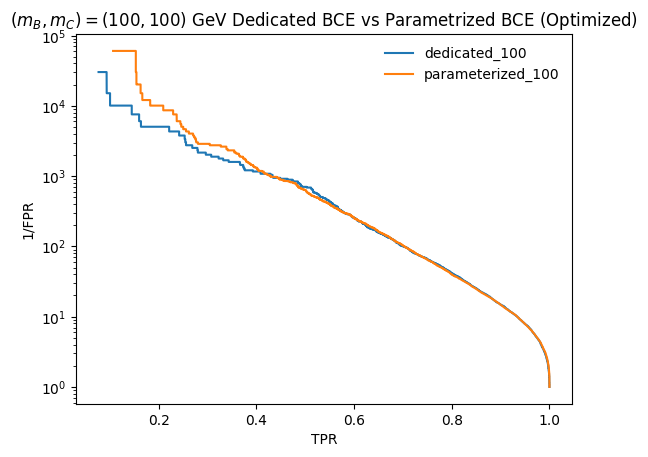

In [87]:
epsilon = 1e-6
plt.plot(tpr_100_BCE,1./(fpr_100_BCE),label="dedicated_100")
plt.plot(tpr_all_BCE,1./(fpr_all_BCE),label="parameterized_100")

plt.yscale("log")
plt.legend(frameon=False)
plt.xlabel("TPR")
plt.ylabel("1/FPR")
plt.title("$(m_B,m_C) = (100,100)$ GeV Dedicated BCE vs Parametrized BCE (Optimized)")

In [247]:
#freezes the layers of the model (i.e all trainable params)
for l in model_all_BCE.layers:
    l.trainable=False

model3 = createSimpleModel(2.)
model32 = createSimpleModel(3.)

#create final model with everything combined
inputs = tf.keras.Input(shape=(4,))
concatenated_inputs = tf.keras.layers.concatenate([inputs, model3(tf.ones_like(inputs)[:,0]), model32(tf.ones_like(inputs)[:,0])])
hidden_layer_1 = model_all_BCE(concatenated_inputs)
model_all2 = Model(inputs = inputs, outputs = hidden_layer_1)
model_all2.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate = 0.01))

In [24]:
model_all2.trainable_weights

[<tf.Variable 'dense_8/kernel:0' shape=(1, 1) dtype=float32, numpy=array([[2.]], dtype=float32)>,
 <tf.Variable 'dense_9/kernel:0' shape=(1, 1) dtype=float32, numpy=array([[3.]], dtype=float32)>]

In [83]:
myhistory_all2 = model_all2.fit(x_vals_100[:,0:4], y_vals_100, epochs=10,validation_data=(X_val_100[:,0:4], Y_val_100),batch_size=1024)

Epoch 1/10
193/193 [==============================] - 1s 3ms/step - loss: 3.0335 - val_loss: 2.8581
Epoch 2/10
193/193 [==============================] - 0s 2ms/step - loss: 2.7964 - val_loss: 2.7314
Epoch 3/10
193/193 [==============================] - 0s 2ms/step - loss: 2.7099 - val_loss: 2.6704
Epoch 4/10
193/193 [==============================] - 0s 2ms/step - loss: 2.6482 - val_loss: 2.6068
Epoch 5/10
193/193 [==============================] - 0s 2ms/step - loss: 2.5891 - val_loss: 2.5549
Epoch 6/10
193/193 [==============================] - 0s 2ms/step - loss: 2.5492 - val_loss: 2.5264
Epoch 7/10
193/193 [==============================] - 0s 2ms/step - loss: 2.5264 - val_loss: 2.5062
Epoch 8/10
193/193 [==============================] - 0s 2ms/step - loss: 2.5055 - val_loss: 2.4842
Epoch 9/10
193/193 [==============================] - 0s 2ms/step - loss: 2.4825 - val_loss: 2.4604
Epoch 10/10
193/193 [==============================] - 0s 2ms/step - loss: 2.4584 - val_loss: 2.4398

In [ ]:
model_all_BCE = tf.keras.models.load_model("model_all_BCE_3_4096")
#model_all_MSE = tf.keras.models.load_model("model_all_MSE_3_4096")

In [ ]:
xx = []
mm = []
for m1 in mass_range[1:]:
        for m2 in mass_range[1:]:

            #freeze layers
            for l in model_all_BCE.layers:
                l.trainable=False

            #create simple models
            model3 = createSimpleModel(1.)
            model32 = createSimpleModel(4.)

            #combine everything
            inputs = tf.keras.Input(shape=(4,))
            inputs2 = tf.keras.layers.concatenate([inputs,model3(tf.ones_like(inputs)[:,0]),model32(tf.ones_like(inputs)[:,0])])
            hidden_layer_1 = model_all_BCE(inputs2)
            model_all2 = Model(inputs = inputs, outputs = hidden_layer_1)
            model_all2.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=tf.keras.optimizers.Adam(learning_rate = 0.01))

            x_vals_ = np.concatenate([x[0,0],x[m1,m2]])
            y_vals_ = np.concatenate([np.zeros(len(x[0,0])),np.ones(len(x[m1,m2]))])
            X_train_, X_val_, Y_train_, Y_val_ = train_test_split(x_vals_, y_vals_, test_size=0.5)
            myhistory_hack_ = model_all2.fit(X_train_[:,0:4], Y_train_, epochs=10,validation_data=(X_val_[:,0:4], Y_val_),batch_size=1024)
            print(m1,m2,np.array(model_all2.trainable_weights).flatten()[0],np.array(model_all2.trainable_weights).flatten()[1])
            xx += [[np.array(model_all2.trainable_weights).flatten()[0],np.array(model_all2.trainable_weights).flatten()[1]]]
            mm += [[m1,m2]]

Epoch 1/10
192/192 [==============================] - 1s 5ms/step - loss: 0.9869 - val_loss: 0.7617
Epoch 2/10
192/192 [==============================] - 1s 4ms/step - loss: 0.7103 - val_loss: 0.6879
Epoch 3/10
192/192 [==============================] - 1s 4ms/step - loss: 0.6838 - val_loss: 0.6872
Epoch 4/10
192/192 [==============================] - 1s 4ms/step - loss: 0.6837 - val_loss: 0.6872
Epoch 5/10
192/192 [==============================] - 1s 4ms/step - loss: 0.6839 - val_loss: 0.6872
Epoch 6/10
192/192 [==============================] - 1s 5ms/step - loss: 0.6840 - val_loss: 0.6874
Epoch 7/10
192/192 [==============================] - 1s 4ms/step - loss: 0.6838 - val_loss: 0.6873
Epoch 8/10
192/192 [==============================] - 1s 4ms/step - loss: 0.6837 - val_loss: 0.6889
Epoch 9/10
192/192 [==============================] - 1s 4ms/step - loss: 0.6839 - val_loss: 0.6873
Epoch 10/10
192/192 [==============================] - 1s 4ms/step - loss: 0.6840 - val_loss: 0.6873

In [274]:
xx = np.array(xx)
mm = np.array(mm)

found_both = 0.
found_one = 0.
found_none = 0.
for i in range(len(mm)):
    diff1 = abs(mm[i][0]-xx[i][0])
    diff2 = abs(mm[i][1]-xx[i][0])
    diff3 = abs(mm[i][0]-xx[i][1])
    diff4 = abs(mm[i][1]-xx[i][1])
    diffs = [diff1,diff2,diff3,diff4]
    if (diff1 < 0.2 and diff4 < 0.2) or (diff2 < 0.2 and diff3 < 0.2):
        #print(mm[i],xx[i])
        found_both+=1
    elif (min(diffs) < 0.2):
        print(mm[i],xx[i])
        found_one+=1
        pass
    else:
        print(mm[i],xx[i])
        found_none+=1
        pass

print("found both:",found_both/(found_both+found_one+found_none))
print("found one:",found_one/(found_both+found_one+found_none))
print("found none:",found_none/(found_both+found_one+found_none))

[0.5 0.5] [0.51142263 6.7378454 ]
[0.5 1. ] [0.5973773 7.1714735]
[0.5 1.5] [1.5079887 7.4636626]
[1.  0.5] [0.6136622 7.126277 ]
[1. 1.] [0.986506  7.2390375]
[1.  1.5] [1.1053972 7.4967775]
[1.5 0.5] [1.5069221 7.5023656]
[1.5 1. ] [1.0532012 7.421378 ]
[1.5 1.5] [1.4985871 6.466111 ]
[4.  4.5] [2.8875525 4.4285445]
[4.5 4. ] [1.0387179 4.3993835]
[4.5 4.5] [1.0719916 4.5687556]
[4.5 5. ] [1.1336992 4.9292355]
[5.  4.5] [1.0286508 4.9457707]
[5. 5.] [3.8444164 5.1046042]
[5.  5.5] [1.2402148 5.479842 ]
[5. 6.] [1.5420388 5.764651 ]
[6.  5.5] [4.327569 5.898191]
[6. 6.] [4.787635 6.132607]
found both: 0.8680555555555556
found one: 0.125
found none: 0.006944444444444444


In [6]:
def createSimpleModel(weight):
    input_layer = tf.keras.Input(shape=(1,))
    simple_model = Dense(1,use_bias = False,activation="relu",
                         kernel_initializer=tf.keras.initializers.Constant(weight))(input_layer)
    model = Model(inputs=input_layer, outputs=simple_model)
    return model

In [22]:
m1_list = np.unique(x_vals_all[:, -2])
m2_list = np.unique(x_vals_all[:, -1])

In [38]:
m1_list == np.array(mass_range[1:])

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True])

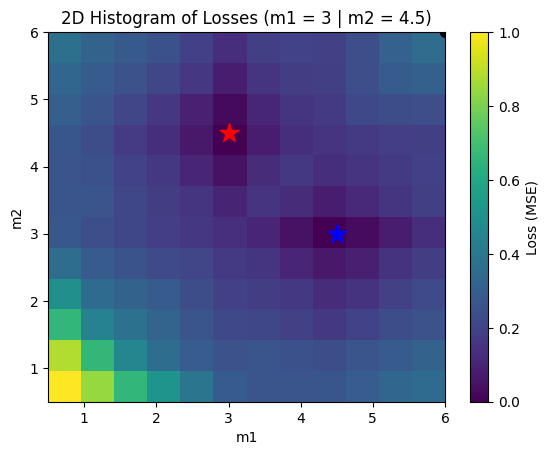

In [68]:
def loss_landscape_2D(m1, m2, w1_out, w2_out):
    m1_values, m2_values = zip(*z.keys())

    loss_values = list(z.values())
    min_loss = min(loss_values)
    max_loss = max(loss_values)

    star1_coords = (m1, m2)  
    star2_coords = (m2, m1)
    fitoutput_coords = (w1_out, w2_out)

    normalized_loss = [(x - min_loss) / (max_loss - min_loss) for x in loss_values]
    
    h = plt.hist2d(m1_values, m2_values, bins=(12, 12), cmap='viridis', weights=normalized_loss)
    plt.scatter(*star1_coords, c='red', marker='*', s=200, label='Star 1')
    plt.scatter(*star2_coords, c='blue', marker='*', s=200, label='Star 2')
    plt.scatter(*fitoutput_coords, c='black', marker='.', s=200, label='fit_output')
    plt.colorbar(label='Loss (MSE)')

    plt.xlabel('m1')
    plt.ylabel('m2')
    plt.title('2D Histogram of Losses (m1 = {}'.format(m1) + " | m2 = {})".format(m2))
    return h

loss_landscape_2D(m1, m2, w1, w2);

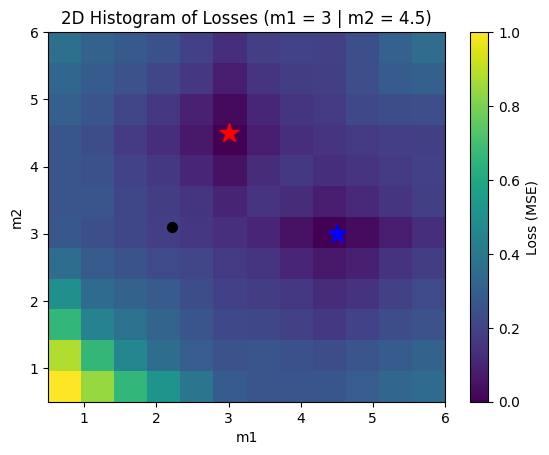

In [99]:
from IPython.display import display, clear_output
for key, value in fit_out.items():
    w1_fit_coord = value[0]
    w2_fit_coord = value[1]
    
    plt.figure()
    loss_landscape_2D(m1, m2, w1_fit_coord, w2_fit_coord)
    plt.show()
    clear_output(wait=True)

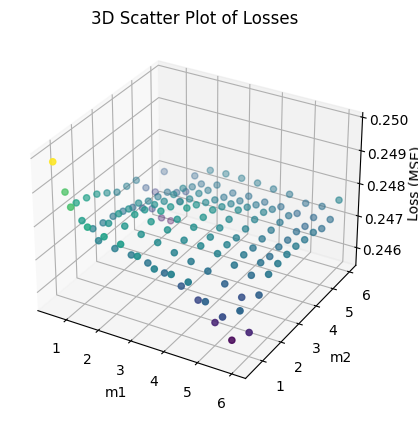

In [125]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

m1_values, m2_values = zip(*z.keys())

loss_values = list(z.values())

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(m1_values, m2_values, loss_values, c=loss_values, cmap='viridis')

ax.set_xlabel('m1')
ax.set_ylabel('m2')
ax.set_zlabel('Loss (MSE)')
ax.set_title('3D Scatter Plot of Losses')

plt.show()

In [139]:
sig_list

[0.001,
 0.0012742749857031334,
 0.001623776739188721,
 0.00206913808111479,
 0.0026366508987303583,
 0.003359818286283781,
 0.004281332398719396,
 0.00545559478116852,
 0.0069519279617756054,
 0.008858667904100823,
 0.011288378916846888,
 0.01438449888287663,
 0.018329807108324356,
 0.023357214690901212,
 0.029763514416313176,
 0.0379269019073225,
 0.04832930238571752,
 0.06158482110660261,
 0.07847599703514611,
 0.1]

1.446 4.904 0.001
30232 90698 30 0.0009923260121725325
Epoch 1/35
30/30 [==============================] - 1s 15ms/step - loss: 0.6931 - val_loss: 0.6932
Epoch 2/35
30/30 [==============================] - 0s 6ms/step - loss: 0.6931 - val_loss: 0.6932
Epoch 3/35
30/30 [==============================] - 0s 15ms/step - loss: 0.6931 - val_loss: 0.6931
Epoch 4/35
30/30 [==============================] - 0s 7ms/step - loss: 0.6931 - val_loss: 0.6932
Epoch 5/35
30/30 [==============================] - 0s 8ms/step - loss: 0.6931 - val_loss: 0.6931
Epoch 6/35
30/30 [==============================] - 0s 8ms/step - loss: 0.6931 - val_loss: 0.6932
Epoch 7/35
30/30 [==============================] - 0s 8ms/step - loss: 0.6931 - val_loss: 0.6932
Epoch 8/35
30/30 [==============================] - 0s 11ms/step - loss: 0.6931 - val_loss: 0.6932
Epoch 9/35
30/30 [==============================] - 0s 15ms/step - loss: 0.6931 - val_loss: 0.6932
Epoch 10/35
30/30 [==============================] - 0s 5ms

/tmp/ipykernel_339593/3356661836.py:89: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_339593/3356661836.py:89: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_339593/3356661836.py:90: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))
/tmp/ipykernel_339593/3356661836.py:90: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


30/30 [==============================] - 1s 11ms/step - loss: 0.6931 - val_loss: 0.6932
Epoch 2/35
30/30 [==============================] - 0s 7ms/step - loss: 0.6931 - val_loss: 0.6932
Epoch 3/35
30/30 [==============================] - 0s 8ms/step - loss: 0.6931 - val_loss: 0.6932
Epoch 4/35
30/30 [==============================] - 0s 9ms/step - loss: 0.6931 - val_loss: 0.6932
Epoch 5/35
30/30 [==============================] - 0s 14ms/step - loss: 0.6931 - val_loss: 0.6932
Epoch 6/35
30/30 [==============================] - 0s 11ms/step - loss: 0.6931 - val_loss: 0.6932
Epoch 7/35
30/30 [==============================] - 0s 6ms/step - loss: 0.6931 - val_loss: 0.6932
Epoch 8/35
30/30 [==============================] - 0s 6ms/step - loss: 0.6931 - val_loss: 0.6932
Epoch 9/35
30/30 [==============================] - 0s 6ms/step - loss: 0.6931 - val_loss: 0.6932
Epoch 10/35
30/30 [==============================] - 0s 6ms/step - loss: 0.6931 - val_loss: 0.6932
Epoch 11/35
30/30 [========

/tmp/ipykernel_339593/3356661836.py:89: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_339593/3356661836.py:89: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_339593/3356661836.py:90: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


30/30 [==============================] - 1s 16ms/step - loss: 0.6932 - val_loss: 0.6931
Epoch 2/35
30/30 [==============================] - 0s 11ms/step - loss: 0.6931 - val_loss: 0.6931
Epoch 3/35
30/30 [==============================] - 0s 6ms/step - loss: 0.6931 - val_loss: 0.6931
Epoch 4/35
30/30 [==============================] - 0s 6ms/step - loss: 0.6931 - val_loss: 0.6931
Epoch 5/35
30/30 [==============================] - 0s 6ms/step - loss: 0.6931 - val_loss: 0.6931
Epoch 6/35
30/30 [==============================] - 0s 6ms/step - loss: 0.6931 - val_loss: 0.6931
Epoch 7/35
30/30 [==============================] - 0s 7ms/step - loss: 0.6931 - val_loss: 0.6931
Epoch 8/35
30/30 [==============================] - 0s 16ms/step - loss: 0.6931 - val_loss: 0.6931
Epoch 9/35
30/30 [==============================] - 0s 10ms/step - loss: 0.6931 - val_loss: 0.6931
Epoch 10/35
30/30 [==============================] - 0s 13ms/step - loss: 0.6931 - val_loss: 0.6931
Epoch 11/35
30/30 [======

/tmp/ipykernel_339593/3356661836.py:89: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_339593/3356661836.py:89: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_339593/3356661836.py:90: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))
/tmp/ipykernel_339593/3356661836.py:90: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


30/30 [==============================] - 1s 15ms/step - loss: 0.6931 - val_loss: 0.6931
Epoch 2/35
30/30 [==============================] - 0s 6ms/step - loss: 0.6931 - val_loss: 0.6931
Epoch 3/35
30/30 [==============================] - 0s 6ms/step - loss: 0.6931 - val_loss: 0.6931
Epoch 4/35
30/30 [==============================] - 0s 7ms/step - loss: 0.6931 - val_loss: 0.6931
Epoch 5/35
30/30 [==============================] - 0s 8ms/step - loss: 0.6931 - val_loss: 0.6931
Epoch 6/35
30/30 [==============================] - 0s 8ms/step - loss: 0.6931 - val_loss: 0.6931
Epoch 7/35
30/30 [==============================] - 0s 9ms/step - loss: 0.6931 - val_loss: 0.6931
Epoch 8/35
30/30 [==============================] - 0s 11ms/step - loss: 0.6931 - val_loss: 0.6931
Epoch 9/35
30/30 [==============================] - 0s 15ms/step - loss: 0.6931 - val_loss: 0.6931
Epoch 10/35
30/30 [==============================] - 0s 5ms/step - loss: 0.6931 - val_loss: 0.6931
Epoch 11/35
30/30 [========

/tmp/ipykernel_339593/3356661836.py:89: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_339593/3356661836.py:89: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_339593/3356661836.py:90: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


30/30 [==============================] - 1s 11ms/step - loss: 0.6931 - val_loss: 0.6932
Epoch 2/35
30/30 [==============================] - 0s 7ms/step - loss: 0.6931 - val_loss: 0.6931
Epoch 3/35
30/30 [==============================] - 0s 8ms/step - loss: 0.6931 - val_loss: 0.6931
Epoch 4/35
30/30 [==============================] - 0s 8ms/step - loss: 0.6931 - val_loss: 0.6931
Epoch 5/35
30/30 [==============================] - 0s 9ms/step - loss: 0.6931 - val_loss: 0.6931
Epoch 6/35
30/30 [==============================] - 0s 13ms/step - loss: 0.6931 - val_loss: 0.6931
Epoch 7/35
30/30 [==============================] - 0s 11ms/step - loss: 0.6931 - val_loss: 0.6931
Epoch 8/35
30/30 [==============================] - 0s 6ms/step - loss: 0.6931 - val_loss: 0.6931
Epoch 9/35
30/30 [==============================] - 0s 6ms/step - loss: 0.6931 - val_loss: 0.6931
Epoch 10/35
30/30 [==============================] - 0s 6ms/step - loss: 0.6931 - val_loss: 0.6931
Epoch 11/35
30/30 [========

/tmp/ipykernel_339593/3356661836.py:89: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_339593/3356661836.py:89: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_339593/3356661836.py:90: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


30/30 [==============================] - 1s 10ms/step - loss: 0.6931 - val_loss: 0.6932
Epoch 2/35
30/30 [==============================] - 0s 8ms/step - loss: 0.6931 - val_loss: 0.6932
Epoch 3/35
30/30 [==============================] - 0s 8ms/step - loss: 0.6930 - val_loss: 0.6932
Epoch 4/35
30/30 [==============================] - 0s 8ms/step - loss: 0.6930 - val_loss: 0.6931
Epoch 5/35
30/30 [==============================] - 0s 11ms/step - loss: 0.6930 - val_loss: 0.6931
Epoch 6/35
30/30 [==============================] - 0s 15ms/step - loss: 0.6930 - val_loss: 0.6931
Epoch 7/35
30/30 [==============================] - 0s 6ms/step - loss: 0.6930 - val_loss: 0.6931
Epoch 8/35
30/30 [==============================] - 0s 6ms/step - loss: 0.6930 - val_loss: 0.6931
Epoch 9/35
30/30 [==============================] - 0s 15ms/step - loss: 0.6930 - val_loss: 0.6931
Epoch 10/35
30/30 [==============================] - 0s 7ms/step - loss: 0.6930 - val_loss: 0.6931
Epoch 11/35
30/30 [=======

/tmp/ipykernel_339593/3356661836.py:89: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_339593/3356661836.py:89: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_339593/3356661836.py:90: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


30/30 [==============================] - 2s 54ms/step - loss: 0.6932 - val_loss: 0.6932
Epoch 2/35
30/30 [==============================] - 0s 7ms/step - loss: 0.6931 - val_loss: 0.6931
Epoch 3/35
30/30 [==============================] - 0s 7ms/step - loss: 0.6931 - val_loss: 0.6931
Epoch 4/35
30/30 [==============================] - 0s 8ms/step - loss: 0.6931 - val_loss: 0.6931
Epoch 5/35
30/30 [==============================] - 0s 8ms/step - loss: 0.6931 - val_loss: 0.6931
Epoch 6/35
30/30 [==============================] - 0s 9ms/step - loss: 0.6931 - val_loss: 0.6931
Epoch 7/35
30/30 [==============================] - 0s 12ms/step - loss: 0.6931 - val_loss: 0.6931
Epoch 8/35
30/30 [==============================] - 0s 14ms/step - loss: 0.6931 - val_loss: 0.6931
Epoch 9/35
30/30 [==============================] - 0s 6ms/step - loss: 0.6931 - val_loss: 0.6931
Epoch 10/35
30/30 [==============================] - 0s 6ms/step - loss: 0.6931 - val_loss: 0.6931
Epoch 11/35
30/30 [========

/tmp/ipykernel_339593/3356661836.py:89: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_339593/3356661836.py:89: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_339593/3356661836.py:90: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))
/tmp/ipykernel_339593/3356661836.py:90: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


30/30 [==============================] - 1s 12ms/step - loss: 0.6932 - val_loss: 0.6932
Epoch 2/35
30/30 [==============================] - 0s 9ms/step - loss: 0.6932 - val_loss: 0.6932
Epoch 3/35
30/30 [==============================] - 0s 14ms/step - loss: 0.6931 - val_loss: 0.6932
Epoch 4/35
30/30 [==============================] - 0s 11ms/step - loss: 0.6931 - val_loss: 0.6931
Epoch 5/35
30/30 [==============================] - 0s 6ms/step - loss: 0.6931 - val_loss: 0.6931
Epoch 6/35
30/30 [==============================] - 0s 7ms/step - loss: 0.6931 - val_loss: 0.6931
Epoch 7/35
30/30 [==============================] - 0s 6ms/step - loss: 0.6931 - val_loss: 0.6931
Epoch 8/35
30/30 [==============================] - 0s 6ms/step - loss: 0.6931 - val_loss: 0.6931
Epoch 9/35
30/30 [==============================] - 0s 8ms/step - loss: 0.6931 - val_loss: 0.6931
Epoch 10/35
30/30 [==============================] - 0s 8ms/step - loss: 0.6931 - val_loss: 0.6931
Epoch 11/35
30/30 [========

/tmp/ipykernel_339593/3356661836.py:89: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_339593/3356661836.py:89: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_339593/3356661836.py:90: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


30/30 [==============================] - 1s 27ms/step - loss: 0.6933 - val_loss: 0.6931
Epoch 2/35
30/30 [==============================] - 0s 6ms/step - loss: 0.6932 - val_loss: 0.6931
Epoch 3/35
30/30 [==============================] - 0s 6ms/step - loss: 0.6931 - val_loss: 0.6931
Epoch 4/35
30/30 [==============================] - 0s 6ms/step - loss: 0.6930 - val_loss: 0.6931
Epoch 5/35
30/30 [==============================] - 0s 7ms/step - loss: 0.6930 - val_loss: 0.6931
Epoch 6/35
30/30 [==============================] - 0s 8ms/step - loss: 0.6930 - val_loss: 0.6931
Epoch 7/35
30/30 [==============================] - 0s 8ms/step - loss: 0.6930 - val_loss: 0.6931
Epoch 8/35
30/30 [==============================] - 0s 8ms/step - loss: 0.6930 - val_loss: 0.6931
Epoch 9/35
30/30 [==============================] - 0s 8ms/step - loss: 0.6930 - val_loss: 0.6931
Epoch 10/35
30/30 [==============================] - 0s 13ms/step - loss: 0.6930 - val_loss: 0.6931
Epoch 11/35
30/30 [=========

/tmp/ipykernel_339593/3356661836.py:89: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_339593/3356661836.py:89: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_339593/3356661836.py:90: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))
/tmp/ipykernel_339593/3356661836.py:90: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


30/30 [==============================] - 1s 11ms/step - loss: 0.6931 - val_loss: 0.6933
Epoch 2/35
30/30 [==============================] - 0s 7ms/step - loss: 0.6931 - val_loss: 0.6933
Epoch 3/35
30/30 [==============================] - 0s 8ms/step - loss: 0.6931 - val_loss: 0.6933
Epoch 4/35
30/30 [==============================] - 0s 8ms/step - loss: 0.6931 - val_loss: 0.6934
Epoch 5/35
30/30 [==============================] - 0s 9ms/step - loss: 0.6931 - val_loss: 0.6933
Epoch 6/35
30/30 [==============================] - 0s 14ms/step - loss: 0.6931 - val_loss: 0.6934
Epoch 7/35
30/30 [==============================] - 0s 10ms/step - loss: 0.6931 - val_loss: 0.6933
Epoch 8/35
30/30 [==============================] - 0s 6ms/step - loss: 0.6931 - val_loss: 0.6933
Epoch 9/35
30/30 [==============================] - 0s 6ms/step - loss: 0.6931 - val_loss: 0.6933
Epoch 10/35
30/30 [==============================] - 0s 6ms/step - loss: 0.6930 - val_loss: 0.6933
Epoch 11/35
30/30 [========

/tmp/ipykernel_339593/3356661836.py:89: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_339593/3356661836.py:89: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_339593/3356661836.py:90: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))
/tmp/ipykernel_339593/3356661836.py:90: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


30/30 [==============================] - 1s 13ms/step - loss: 0.6930 - val_loss: 0.6935
Epoch 2/35
30/30 [==============================] - 0s 14ms/step - loss: 0.6930 - val_loss: 0.6935
Epoch 3/35
30/30 [==============================] - 1s 17ms/step - loss: 0.6930 - val_loss: 0.6934
Epoch 4/35
30/30 [==============================] - 0s 6ms/step - loss: 0.6929 - val_loss: 0.6933
Epoch 5/35
30/30 [==============================] - 0s 6ms/step - loss: 0.6928 - val_loss: 0.6932
Epoch 6/35
30/30 [==============================] - 0s 6ms/step - loss: 0.6927 - val_loss: 0.6932
Epoch 7/35
30/30 [==============================] - 0s 7ms/step - loss: 0.6927 - val_loss: 0.6932
Epoch 8/35
30/30 [==============================] - 0s 7ms/step - loss: 0.6927 - val_loss: 0.6932
Epoch 9/35
30/30 [==============================] - 0s 8ms/step - loss: 0.6927 - val_loss: 0.6933
Epoch 10/35
30/30 [==============================] - 0s 9ms/step - loss: 0.6926 - val_loss: 0.6933
Epoch 11/35
30/30 [========

/tmp/ipykernel_339593/3356661836.py:89: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_339593/3356661836.py:89: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_339593/3356661836.py:90: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))
/tmp/ipykernel_339593/3356661836.py:90: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


30/30 [==============================] - 1s 10ms/step - loss: 0.6932 - val_loss: 0.6933
Epoch 2/35
30/30 [==============================] - 0s 6ms/step - loss: 0.6932 - val_loss: 0.6933
Epoch 3/35
30/30 [==============================] - 0s 7ms/step - loss: 0.6932 - val_loss: 0.6933
Epoch 4/35
30/30 [==============================] - 0s 7ms/step - loss: 0.6931 - val_loss: 0.6933
Epoch 5/35
30/30 [==============================] - 0s 8ms/step - loss: 0.6930 - val_loss: 0.6931
Epoch 6/35
30/30 [==============================] - 0s 8ms/step - loss: 0.6930 - val_loss: 0.6930
Epoch 7/35
30/30 [==============================] - 0s 10ms/step - loss: 0.6930 - val_loss: 0.6930
Epoch 8/35
30/30 [==============================] - 0s 15ms/step - loss: 0.6929 - val_loss: 0.6929
Epoch 9/35
30/30 [==============================] - 0s 7ms/step - loss: 0.6930 - val_loss: 0.6929
Epoch 10/35
30/30 [==============================] - 0s 6ms/step - loss: 0.6929 - val_loss: 0.6929
Epoch 11/35
30/30 [========

/tmp/ipykernel_339593/3356661836.py:89: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_339593/3356661836.py:89: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_339593/3356661836.py:90: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))
/tmp/ipykernel_339593/3356661836.py:90: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


30/30 [==============================] - 1s 12ms/step - loss: 0.6933 - val_loss: 0.6932
Epoch 2/35
30/30 [==============================] - 0s 9ms/step - loss: 0.6931 - val_loss: 0.6931
Epoch 3/35
30/30 [==============================] - 0s 11ms/step - loss: 0.6929 - val_loss: 0.6929
Epoch 4/35
30/30 [==============================] - 0s 15ms/step - loss: 0.6927 - val_loss: 0.6929
Epoch 5/35
30/30 [==============================] - 0s 6ms/step - loss: 0.6926 - val_loss: 0.6929
Epoch 6/35
30/30 [==============================] - 0s 6ms/step - loss: 0.6926 - val_loss: 0.6928
Epoch 7/35
30/30 [==============================] - 0s 6ms/step - loss: 0.6926 - val_loss: 0.6928
Epoch 8/35
30/30 [==============================] - 0s 6ms/step - loss: 0.6926 - val_loss: 0.6928
Epoch 9/35
30/30 [==============================] - 0s 7ms/step - loss: 0.6926 - val_loss: 0.6928
Epoch 10/35
30/30 [==============================] - 0s 7ms/step - loss: 0.6926 - val_loss: 0.6928
Epoch 11/35
30/30 [========

/tmp/ipykernel_339593/3356661836.py:89: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_339593/3356661836.py:89: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_339593/3356661836.py:90: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))
/tmp/ipykernel_339593/3356661836.py:90: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


30/30 [==============================] - 1s 18ms/step - loss: 0.6934 - val_loss: 0.6931
Epoch 2/35
30/30 [==============================] - 0s 6ms/step - loss: 0.6932 - val_loss: 0.6931
Epoch 3/35
30/30 [==============================] - 0s 6ms/step - loss: 0.6930 - val_loss: 0.6931
Epoch 4/35
30/30 [==============================] - 0s 6ms/step - loss: 0.6930 - val_loss: 0.6932
Epoch 5/35
30/30 [==============================] - 0s 6ms/step - loss: 0.6929 - val_loss: 0.6932
Epoch 6/35
30/30 [==============================] - 0s 7ms/step - loss: 0.6929 - val_loss: 0.6932
Epoch 7/35
30/30 [==============================] - 0s 13ms/step - loss: 0.6929 - val_loss: 0.6932
Epoch 8/35
30/30 [==============================] - 0s 8ms/step - loss: 0.6929 - val_loss: 0.6932
Epoch 9/35
30/30 [==============================] - 0s 9ms/step - loss: 0.6930 - val_loss: 0.6932
Epoch 10/35
30/30 [==============================] - 0s 14ms/step - loss: 0.6929 - val_loss: 0.6932
Epoch 11/35
30/30 [========

/tmp/ipykernel_339593/3356661836.py:89: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_339593/3356661836.py:89: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_339593/3356661836.py:90: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))
/tmp/ipykernel_339593/3356661836.py:90: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


30/30 [==============================] - 1s 9ms/step - loss: 0.6932 - val_loss: 0.6933
Epoch 2/35
30/30 [==============================] - 0s 6ms/step - loss: 0.6931 - val_loss: 0.6932
Epoch 3/35
30/30 [==============================] - 0s 6ms/step - loss: 0.6930 - val_loss: 0.6930
Epoch 4/35
30/30 [==============================] - 0s 7ms/step - loss: 0.6927 - val_loss: 0.6927
Epoch 5/35
30/30 [==============================] - 0s 7ms/step - loss: 0.6923 - val_loss: 0.6925
Epoch 6/35
30/30 [==============================] - 0s 8ms/step - loss: 0.6921 - val_loss: 0.6924
Epoch 7/35
30/30 [==============================] - 0s 8ms/step - loss: 0.6920 - val_loss: 0.6922
Epoch 8/35
30/30 [==============================] - 0s 9ms/step - loss: 0.6918 - val_loss: 0.6917
Epoch 9/35
30/30 [==============================] - 0s 15ms/step - loss: 0.6911 - val_loss: 0.6906
Epoch 10/35
30/30 [==============================] - 0s 9ms/step - loss: 0.6893 - val_loss: 0.6887
Epoch 11/35
30/30 [==========

/tmp/ipykernel_339593/3356661836.py:89: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_339593/3356661836.py:89: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_339593/3356661836.py:90: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))
/tmp/ipykernel_339593/3356661836.py:90: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


31/31 [==============================] - 1s 9ms/step - loss: 0.6931 - val_loss: 0.6936
Epoch 2/35
31/31 [==============================] - 0s 6ms/step - loss: 0.6930 - val_loss: 0.6932
Epoch 3/35
31/31 [==============================] - 0s 7ms/step - loss: 0.6926 - val_loss: 0.6929
Epoch 4/35
31/31 [==============================] - 0s 7ms/step - loss: 0.6924 - val_loss: 0.6924
Epoch 5/35
31/31 [==============================] - 0s 8ms/step - loss: 0.6919 - val_loss: 0.6922
Epoch 6/35
31/31 [==============================] - 0s 8ms/step - loss: 0.6916 - val_loss: 0.6920
Epoch 7/35
31/31 [==============================] - 0s 12ms/step - loss: 0.6914 - val_loss: 0.6917
Epoch 8/35
31/31 [==============================] - 0s 14ms/step - loss: 0.6913 - val_loss: 0.6911
Epoch 9/35
31/31 [==============================] - 0s 6ms/step - loss: 0.6907 - val_loss: 0.6900
Epoch 10/35
31/31 [==============================] - 0s 6ms/step - loss: 0.6896 - val_loss: 0.6882
Epoch 11/35
31/31 [=========

/tmp/ipykernel_339593/3356661836.py:89: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_339593/3356661836.py:89: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_339593/3356661836.py:90: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))
/tmp/ipykernel_339593/3356661836.py:90: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


31/31 [==============================] - 1s 9ms/step - loss: 0.6935 - val_loss: 0.6929
Epoch 2/35
31/31 [==============================] - 0s 7ms/step - loss: 0.6923 - val_loss: 0.6920
Epoch 3/35
31/31 [==============================] - 0s 7ms/step - loss: 0.6911 - val_loss: 0.6915
Epoch 4/35
31/31 [==============================] - 0s 8ms/step - loss: 0.6902 - val_loss: 0.6906
Epoch 5/35
31/31 [==============================] - 0s 8ms/step - loss: 0.6891 - val_loss: 0.6889
Epoch 6/35
31/31 [==============================] - 0s 9ms/step - loss: 0.6866 - val_loss: 0.6859
Epoch 7/35
31/31 [==============================] - 0s 14ms/step - loss: 0.6843 - val_loss: 0.6852
Epoch 8/35
31/31 [==============================] - 0s 9ms/step - loss: 0.6840 - val_loss: 0.6852
Epoch 9/35
31/31 [==============================] - 0s 13ms/step - loss: 0.6840 - val_loss: 0.6852
Epoch 10/35
31/31 [==============================] - 0s 6ms/step - loss: 0.6840 - val_loss: 0.6852
Epoch 11/35
31/31 [=========

/tmp/ipykernel_339593/3356661836.py:89: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_339593/3356661836.py:89: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_339593/3356661836.py:90: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))
/tmp/ipykernel_339593/3356661836.py:90: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


31/31 [==============================] - 1s 18ms/step - loss: 0.6929 - val_loss: 0.6923
Epoch 2/35
31/31 [==============================] - 0s 14ms/step - loss: 0.6915 - val_loss: 0.6910
Epoch 3/35
31/31 [==============================] - 0s 9ms/step - loss: 0.6908 - val_loss: 0.6901
Epoch 4/35
31/31 [==============================] - 0s 5ms/step - loss: 0.6902 - val_loss: 0.6893
Epoch 5/35
31/31 [==============================] - 0s 6ms/step - loss: 0.6886 - val_loss: 0.6875
Epoch 6/35
31/31 [==============================] - 0s 6ms/step - loss: 0.6853 - val_loss: 0.6836
Epoch 7/35
31/31 [==============================] - 0s 6ms/step - loss: 0.6821 - val_loss: 0.6823
Epoch 8/35
31/31 [==============================] - 0s 7ms/step - loss: 0.6814 - val_loss: 0.6823
Epoch 9/35
31/31 [==============================] - 0s 7ms/step - loss: 0.6814 - val_loss: 0.6823
Epoch 10/35
31/31 [==============================] - 0s 7ms/step - loss: 0.6814 - val_loss: 0.6823
Epoch 11/35
31/31 [=========

/tmp/ipykernel_339593/3356661836.py:89: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_339593/3356661836.py:89: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_339593/3356661836.py:90: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))
/tmp/ipykernel_339593/3356661836.py:90: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


31/31 [==============================] - 2s 18ms/step - loss: 0.6932 - val_loss: 0.6922
Epoch 2/35
31/31 [==============================] - 0s 10ms/step - loss: 0.6921 - val_loss: 0.6913
Epoch 3/35
31/31 [==============================] - 0s 6ms/step - loss: 0.6913 - val_loss: 0.6900
Epoch 4/35
31/31 [==============================] - 0s 6ms/step - loss: 0.6900 - val_loss: 0.6885
Epoch 5/35
31/31 [==============================] - 0s 6ms/step - loss: 0.6889 - val_loss: 0.6867
Epoch 6/35
31/31 [==============================] - 0s 6ms/step - loss: 0.6865 - val_loss: 0.6829
Epoch 7/35
31/31 [==============================] - 0s 7ms/step - loss: 0.6811 - val_loss: 0.6784
Epoch 8/35
31/31 [==============================] - 0s 8ms/step - loss: 0.6787 - val_loss: 0.6780
Epoch 9/35
31/31 [==============================] - 0s 9ms/step - loss: 0.6786 - val_loss: 0.6780
Epoch 10/35
31/31 [==============================] - 1s 20ms/step - loss: 0.6786 - val_loss: 0.6780
Epoch 11/35
31/31 [========

/tmp/ipykernel_339593/3356661836.py:89: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_339593/3356661836.py:89: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_339593/3356661836.py:90: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))
/tmp/ipykernel_339593/3356661836.py:90: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


31/31 [==============================] - 1s 14ms/step - loss: 0.6932 - val_loss: 0.6907
Epoch 2/35
31/31 [==============================] - 0s 8ms/step - loss: 0.6902 - val_loss: 0.6883
Epoch 3/35
31/31 [==============================] - 0s 4ms/step - loss: 0.6877 - val_loss: 0.6858
Epoch 4/35
31/31 [==============================] - 0s 5ms/step - loss: 0.6845 - val_loss: 0.6811
Epoch 5/35
31/31 [==============================] - 0s 5ms/step - loss: 0.6794 - val_loss: 0.6751
Epoch 6/35
31/31 [==============================] - 0s 5ms/step - loss: 0.6750 - val_loss: 0.6739
Epoch 7/35
31/31 [==============================] - 0s 5ms/step - loss: 0.6745 - val_loss: 0.6739
Epoch 8/35
31/31 [==============================] - 0s 5ms/step - loss: 0.6745 - val_loss: 0.6739
Epoch 9/35
31/31 [==============================] - 0s 5ms/step - loss: 0.6745 - val_loss: 0.6739
Epoch 10/35
31/31 [==============================] - 0s 6ms/step - loss: 0.6745 - val_loss: 0.6739
Epoch 11/35
31/31 [==========

/tmp/ipykernel_339593/3356661836.py:89: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_339593/3356661836.py:89: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_339593/3356661836.py:90: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))
/tmp/ipykernel_339593/3356661836.py:90: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


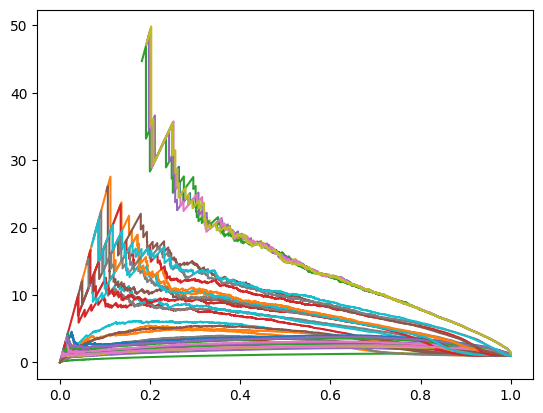

In [113]:
xx = []
yy = []
zz = []
ww = []

msic1 = []
msic2 = []

w1 = round(random.uniform(0.5, 6.0),3)
w2 = round(random.uniform(0.5, 6.0),3)

epsilon = 1e-6

# initial_learning_rate = 0.05 #placeholder till callback

# lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
#     initial_learning_rate, decay_steps=30*3, decay_rate=0.8, staircase=True
# )

for sigfrac in np.logspace(-3,-1,20):
    print(w1, w2, sigfrac)
    #sigfrac = 0.05
    if (sigfrac > 0.5):
        continue

    for l in model_all.layers:
        l.trainable=False

    inputs_hold = tf.keras.Input(shape=(1,))
    simple_model = Dense(1,use_bias = False,activation='relu',kernel_initializer=tf.keras.initializers.Constant(w1))(inputs_hold)
    model3 = Model(inputs = inputs_hold, outputs = simple_model)

    inputs_hold2 = tf.keras.Input(shape=(1,))
    simple_model2 = Dense(1,use_bias = False,activation='relu',kernel_initializer=tf.keras.initializers.Constant(w2))(inputs_hold2)
    model32 = Model(inputs = inputs_hold2, outputs = simple_model2)

    inputs_hold3 = tf.keras.Input(shape=(1,))
    simple_model3 = tf.exp(Dense(1,use_bias = False,activation='linear',kernel_initializer=tf.keras.initializers.Constant(-1))(inputs_hold3))
    model33 = Model(inputs = inputs_hold3, outputs = simple_model3)

    inputs = tf.keras.Input(shape=(4,))
    inputs2 = tf.keras.layers.concatenate([inputs,model3(tf.ones_like(inputs)[:,0]),model32(tf.ones_like(inputs)[:,0])])
    hidden_layer_1 = model_all(inputs2)
    LLR = hidden_layer_1 / (1.-hidden_layer_1 + epsilon)
    LLR_xs = 1.+sigfrac*LLR-sigfrac
    #LLR_xs = 1.+model33(tf.ones_like(inputs)[:,0])*LLR
    ws = LLR_xs / (1.+LLR_xs)
    model_all2 = Model(inputs = inputs, outputs = ws)
    model_all2.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate = 0.01))

    m1 = 3
    m2 = 4.5

    test_background = int(1/2 *len(x[0,0]))
    train_background = int(1/4 * len(x[0,0]))
    train_data = int(1/4 * len(x[0,0]))
    train_reference = int(1/4 * len(x[0,0]))
    #signal
    test_signal_length = int(1/2*len(x[m1,m2]))
    N = int(1/4 * (len(x[0,0])))
    #signal = x[m1, m2][test_signal_length:test_signal_length + int(sigfrac*N)]

    x_vals_ = np.concatenate([x[0,0][test_background:],x[m1,m2][test_signal_length:test_signal_length+int(sigfrac*N)]])
    y_vals_ = np.concatenate([np.zeros(train_reference),np.ones(train_data + 1),np.ones(len(x[m1,m2][test_signal_length:test_signal_length+int(sigfrac*N)]))])

    print(N,len(x[0,0])-N,len(x[m1,m2][0:int(sigfrac*N)]),len(x[m1,m2][0:int(sigfrac*N)])/N)

    X_train_, X_val_, Y_train_, Y_val_ = train_test_split(x_vals_, y_vals_, test_size=0.5)

    myhistory_hack_ = model_all2.fit(X_train_[:,0:4], Y_train_, epochs=35,validation_data=(X_val_[:,0:4], Y_val_),batch_size=1024)
    print(m1,m2,model_all2.trainable_weights[0].numpy()[0][0],model_all2.trainable_weights[1].numpy()[0][0])
    xx+=[sigfrac]
    yy+=[model_all2.trainable_weights[0].numpy()[0][0]]
    zz+=[model_all2.trainable_weights[1].numpy()[0][0]]
    #ww+=[np.exp(model_all2.trainable_weights[2].numpy()[0][0])]
    scores = model_all2.predict(np.concatenate([x[0,0][0:test_background],x[m1,m2][0:test_signal_length]]),batch_size=1024)
    y = np.concatenate([np.zeros(test_background),np.ones(test_signal_length)])
    fpr, tpr, _ = metrics.roc_curve(y, scores)
    
    model_cwola = Sequential()
    model_cwola.add(Dense(128, input_dim=4, activation='relu'))
    model_cwola.add(Dense(128, activation='relu'))
    model_cwola.add(Dense(128, activation='relu'))
    model_cwola.add(Dense(1, activation='sigmoid'))
    model_cwola.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    myhistory_cwola = model_cwola.fit(X_train_[:,0:4], Y_train_, epochs=10,validation_data=(X_val_[:,0:4], Y_val_),batch_size=1024)

    scores2 = model_cwola.predict(np.concatenate([x[0,0][0:test_background],x[m1,m2][0:test_signal_length]]),batch_size=1024)
    y2 = np.concatenate([np.zeros(test_background),np.ones(test_signal_length)])
    fpr2, tpr2, _ = metrics.roc_curve(y2, scores2)
    plt.plot(tpr,tpr/np.sqrt(fpr))
    plt.plot(tpr2,tpr2/np.sqrt(fpr2))

    msic1+=[np.max(tpr/np.sqrt(fpr+epsilon))]
    msic2+=[np.max(tpr2/np.sqrt(fpr2+epsilon))]
# plt.title(f"m1 = {m1} m2 = {m2}")
# plt.xlabel("Average TPR")
# plt.ylabel("Average TPR/sqrt(avg_fpr)")

(0.0, 700.0)

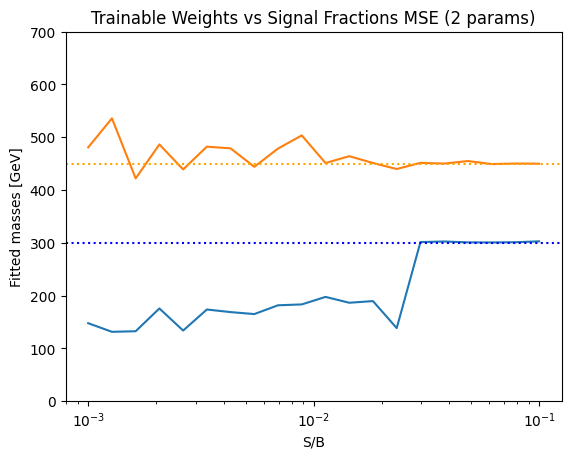

In [114]:
plt.plot(xx,np.array(yy)*100)
plt.plot(xx,np.array(zz)*100)
plt.xscale("log")
plt.xlabel("S/B")
plt.ylabel("Fitted masses [GeV]")
plt.title("Trainable Weights vs Signal Fractions MSE (2 params)")
plt.axhline(m2 * 100,ls=":",color='orange')
plt.axhline(m1 * 100,ls=":",color='blue')
#plt.legend()
plt.ylim([0,700])

In [ ]:
# plt.plot(xx,np.array(ww))
# plt.xscale("log")
# plt.yscale("log")
# plt.plot(xx,xx,ls=":",color="black")
# plt.xlabel("S/B")
# plt.ylabel("Fitted S/B")
# plt.title("S/B vs Fitted S/B")

Text(0, 0.5, 'max SIC')

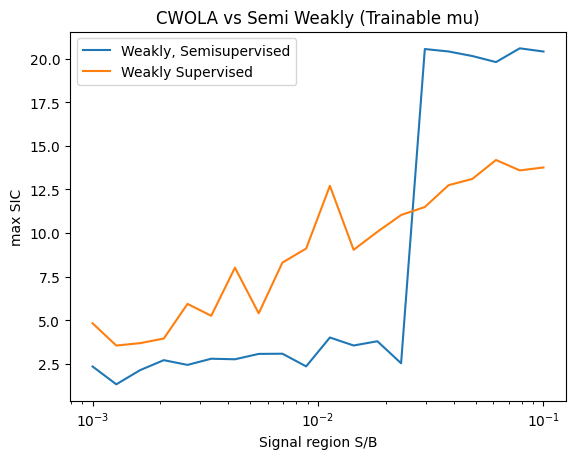

In [115]:
plt.plot(xx,msic1,label="Weakly, Semisupervised")
plt.plot(xx,msic2,label="Weakly Supervised")
plt.title("CWOLA vs Semi Weakly (Trainable mu)")
plt.legend()
plt.xscale("log")
plt.xlabel("Signal region S/B")
plt.ylabel("max SIC")

In [ ]:
num_runs = 5
scores_list_runs = []

msic1_list_runs = []
msic2_list_runs = []

for _ in range(num_runs):

    xx = []
    yy = []
    zz = []
    ww = []

    msic1 = []
    msic2 = []
    
    score_list = []
    
#     initial_learning_rate = 0.05 #placeholder till callback

#     lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
#         initial_learning_rate, decay_steps=30*3, decay_rate=0.8, staircase=True
#     )

    w1 = round(random.uniform(0.5, 6.0),3)
    w2 = round(random.uniform(0.5, 6.0),3)
    
    for sigfrac in np.logspace(-3,-1,20):
        print(w1, w2, sigfrac)
        #sigfrac = 0.05
        if (sigfrac > 0.5):
            continue

        for l in model_all.layers:
            l.trainable=False

        inputs_hold = tf.keras.Input(shape=(1,))
        simple_model = Dense(1,use_bias = False,activation='relu',kernel_initializer=tf.keras.initializers.Constant(w1))(inputs_hold)
        model3 = Model(inputs = inputs_hold, outputs = simple_model)

        inputs_hold2 = tf.keras.Input(shape=(1,))
        simple_model2 = Dense(1,use_bias = False,activation='relu',kernel_initializer=tf.keras.initializers.Constant(w2))(inputs_hold2)
        model32 = Model(inputs = inputs_hold2, outputs = simple_model2)

        inputs_hold3 = tf.keras.Input(shape=(1,))
        simple_model3 = tf.exp(Dense(1,use_bias = False,activation='linear',kernel_initializer=tf.keras.initializers.Constant(-1))(inputs_hold3))
        model33 = Model(inputs = inputs_hold3, outputs = simple_model3)

        inputs = tf.keras.Input(shape=(4,))
        inputs2 = tf.keras.layers.concatenate([inputs,model3(tf.ones_like(inputs)[:,0]),model32(tf.ones_like(inputs)[:,0])])
        hidden_layer_1 = model_all(inputs2)
        LLR = hidden_layer_1 / (1.-hidden_layer_1 + epsilon)
        LLR_xs = 1.+sigfrac*LLR-sigfrac
        #LLR_xs = 1.+model33(tf.ones_like(inputs)[:,0])*LLR
        ws = LLR_xs / (1.+LLR_xs)
        model_all2 = Model(inputs = inputs, outputs = ws)
        model_all2.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate = 0.01))

        m1 = 3
        m2 = 4.5

        test_background = int(1/2 *len(x[0,0]))
        train_background = int(1/4 * len(x[0,0]))
        train_data = int(1/4 * len(x[0,0]))
        train_reference = int(1/4 * len(x[0,0]))
        #signal
        test_signal_length = int(1/2*len(x[m1,m2]))
        N = int(1/4 * (len(x[0,0])))
        #signal = x[m1, m2][test_signal_length:test_signal_length + int(sigfrac*N)]

        x_vals_ = np.concatenate([x[0,0][test_background:],x[m1,m2][test_signal_length:test_signal_length+int(sigfrac*N)]])
        y_vals_ = np.concatenate([np.zeros(train_reference),np.ones(train_data + 1),np.ones(len(x[m1,m2][test_signal_length:test_signal_length+int(sigfrac*N)]))])

        #print(N,len(x[0,0])-N,len(x[m1,m2][0:int(sigfrac*N)]),len(x[m1,m2][0:int(sigfrac*N)])/N)

        X_train_, X_val_, Y_train_, Y_val_ = train_test_split(x_vals_, y_vals_, test_size=0.5)

        myhistory_hack_ = model_all2.fit(X_train_[:,0:4], Y_train_, epochs=35,validation_data=(X_val_[:,0:4], Y_val_),batch_size=1024, verbose = 0)
        print(m1,m2,model_all2.trainable_weights[0].numpy()[0][0],model_all2.trainable_weights[1].numpy()[0][0])
        xx+=[sigfrac]
        yy+=[model_all2.trainable_weights[0].numpy()[0][0]]
        zz+=[model_all2.trainable_weights[1].numpy()[0][0]]
        #ww+=[np.exp(model_all2.trainable_weights[2].numpy()[0][0])]
        scores = model_all2.predict(np.concatenate([x[0,0][0:test_background],x[m1,m2][0:test_signal_length]]),batch_size=1024)
        y = np.concatenate([np.zeros(test_background),np.ones(test_signal_length)])
        fpr, tpr, _ = metrics.roc_curve(y, scores)
        plt.plot(tpr,tpr/np.sqrt(fpr))
        
        score_list.append(scores)

        model_cwola = Sequential()
        model_cwola.add(Dense(128, input_dim=4, activation='relu'))
        model_cwola.add(Dense(128, activation='relu'))
        model_cwola.add(Dense(128, activation='relu'))
        model_cwola.add(Dense(1, activation='sigmoid'))
        model_cwola.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
        myhistory_cwola = model_cwola.fit(X_train_[:,0:4], Y_train_, epochs=10,validation_data=(X_val_[:,0:4], Y_val_),batch_size=1024, verbose = 0)

        scores2 = model_cwola.predict(np.concatenate([x[0,0][0:test_background],x[m1,m2][0:test_signal_length]]),batch_size=1024)
        y2 = np.concatenate([np.zeros(test_background),np.ones(test_signal_length)])
        fpr2, tpr2, _ = metrics.roc_curve(y2, scores2)
        plt.plot(tpr,fpr)
        #plt.plot(tpr2,tpr2/np.sqrt(fpr2))

        msic1+=[np.max(tpr/np.sqrt(fpr+epsilon))]
        msic2+=[np.max(tpr2/np.sqrt(fpr2+epsilon))]
        
    msic1_list_runs.append(msic1)
    msic2_list_runs.append(msic2)

2.177 5.197 0.001
3 4.5 2.441388 4.484941
95/95 [==============================] - 0s 795us/step


/tmp/ipykernel_339593/3047040532.py:87: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_339593/3047040532.py:87: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


95/95 [==============================] - 0s 684us/step
2.177 5.197 0.0012742749857031334
3 4.5 2.5383265 5.194775
95/95 [==============================] - 0s 765us/step


/tmp/ipykernel_339593/3047040532.py:87: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_339593/3047040532.py:87: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


95/95 [==============================] - 0s 698us/step
2.177 5.197 0.001623776739188721
3 4.5 2.6595957 5.4321666
95/95 [==============================] - 0s 734us/step


/tmp/ipykernel_339593/3047040532.py:87: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_339593/3047040532.py:87: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


95/95 [==============================] - 0s 646us/step
2.177 5.197 0.00206913808111479
3 4.5 1.7653104 4.804144
95/95 [==============================] - 0s 793us/step


/tmp/ipykernel_339593/3047040532.py:87: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_339593/3047040532.py:87: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


95/95 [==============================] - 0s 653us/step
2.177 5.197 0.0026366508987303583
3 4.5 2.2608936 5.1948314
95/95 [==============================] - 0s 736us/step


/tmp/ipykernel_339593/3047040532.py:87: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_339593/3047040532.py:87: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


95/95 [==============================] - 0s 616us/step
2.177 5.197 0.003359818286283781
3 4.5 3.1145651 4.876826
95/95 [==============================] - 0s 785us/step


/tmp/ipykernel_339593/3047040532.py:87: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_339593/3047040532.py:87: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


95/95 [==============================] - 0s 676us/step
2.177 5.197 0.004281332398719396
3 4.5 2.9612644 4.5795875
95/95 [==============================] - 0s 807us/step


/tmp/ipykernel_339593/3047040532.py:87: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_339593/3047040532.py:87: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


95/95 [==============================] - 0s 638us/step
2.177 5.197 0.00545559478116852
3 4.5 2.222307 5.056416
95/95 [==============================] - 0s 787us/step


/tmp/ipykernel_339593/3047040532.py:87: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_339593/3047040532.py:87: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


95/95 [==============================] - 0s 652us/step
2.177 5.197 0.0069519279617756054
3 4.5 3.0285008 4.4888673
95/95 [==============================] - 0s 831us/step


/tmp/ipykernel_339593/3047040532.py:87: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_339593/3047040532.py:87: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


95/95 [==============================] - 0s 651us/step
2.177 5.197 0.008858667904100823
3 4.5 2.9049287 4.538271
95/95 [==============================] - 0s 792us/step


/tmp/ipykernel_339593/3047040532.py:87: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_339593/3047040532.py:87: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


95/95 [==============================] - 0s 696us/step
2.177 5.197 0.011288378916846888
3 4.5 2.994243 4.5556345
95/95 [==============================] - 0s 795us/step


/tmp/ipykernel_339593/3047040532.py:87: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_339593/3047040532.py:87: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


95/95 [==============================] - 0s 652us/step
2.177 5.197 0.01438449888287663
3 4.5 2.9836335 4.4988785
95/95 [==============================] - 0s 771us/step


/tmp/ipykernel_339593/3047040532.py:87: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_339593/3047040532.py:87: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


95/95 [==============================] - 0s 675us/step
2.177 5.197 0.018329807108324356
3 4.5 2.9627197 4.5628495
95/95 [==============================] - 0s 765us/step


/tmp/ipykernel_339593/3047040532.py:87: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_339593/3047040532.py:87: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


95/95 [==============================] - 0s 635us/step
2.177 5.197 0.023357214690901212
3 4.5 2.9876192 4.5640464
95/95 [==============================] - 0s 766us/step


/tmp/ipykernel_339593/3047040532.py:87: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_339593/3047040532.py:87: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


95/95 [==============================] - 0s 662us/step
2.177 5.197 0.029763514416313176
3 4.5 2.9813173 4.5378203
95/95 [==============================] - 0s 802us/step


/tmp/ipykernel_339593/3047040532.py:87: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_339593/3047040532.py:87: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


95/95 [==============================] - 0s 650us/step
2.177 5.197 0.0379269019073225
3 4.5 2.9884894 4.5401955
95/95 [==============================] - 0s 777us/step


/tmp/ipykernel_339593/3047040532.py:87: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_339593/3047040532.py:87: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


95/95 [==============================] - 0s 797us/step
2.177 5.197 0.04832930238571752
3 4.5 3.0052247 4.5348644
95/95 [==============================] - 0s 749us/step


/tmp/ipykernel_339593/3047040532.py:87: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_339593/3047040532.py:87: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


95/95 [==============================] - 0s 663us/step
2.177 5.197 0.06158482110660261
3 4.5 3.0198367 4.50202
95/95 [==============================] - 0s 717us/step


/tmp/ipykernel_339593/3047040532.py:87: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_339593/3047040532.py:87: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


95/95 [==============================] - 0s 656us/step
2.177 5.197 0.07847599703514611
3 4.5 3.001942 4.504701
95/95 [==============================] - 0s 767us/step


/tmp/ipykernel_339593/3047040532.py:87: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_339593/3047040532.py:87: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


95/95 [==============================] - 0s 659us/step
2.177 5.197 0.1
3 4.5 3.0359066 4.478758
95/95 [==============================] - 0s 741us/step


/tmp/ipykernel_339593/3047040532.py:87: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_339593/3047040532.py:87: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


95/95 [==============================] - 0s 650us/step
2.782 2.35 0.001
3 4.5 2.7459202 2.2476647
95/95 [==============================] - 0s 772us/step


/tmp/ipykernel_339593/3047040532.py:87: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_339593/3047040532.py:87: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


95/95 [==============================] - 0s 672us/step
2.782 2.35 0.0012742749857031334
3 4.5 3.1105442 2.3073366
95/95 [==============================] - 0s 764us/step


/tmp/ipykernel_339593/3047040532.py:87: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_339593/3047040532.py:87: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


95/95 [==============================] - 0s 655us/step
2.782 2.35 0.001623776739188721
3 4.5 3.0690594 2.1761131
95/95 [==============================] - 0s 814us/step


/tmp/ipykernel_339593/3047040532.py:87: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_339593/3047040532.py:87: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


95/95 [==============================] - 0s 693us/step
2.782 2.35 0.00206913808111479
3 4.5 3.074805 2.2309113
95/95 [==============================] - 0s 764us/step


/tmp/ipykernel_339593/3047040532.py:87: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_339593/3047040532.py:87: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


95/95 [==============================] - 0s 664us/step
2.782 2.35 0.0026366508987303583
3 4.5 2.9716754 2.2993531
95/95 [==============================] - 0s 795us/step


/tmp/ipykernel_339593/3047040532.py:87: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_339593/3047040532.py:87: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


95/95 [==============================] - 0s 699us/step
2.782 2.35 0.003359818286283781
3 4.5 3.0545716 2.2730067
95/95 [==============================] - 0s 815us/step


/tmp/ipykernel_339593/3047040532.py:87: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_339593/3047040532.py:87: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


95/95 [==============================] - 0s 669us/step
2.782 2.35 0.004281332398719396
3 4.5 3.1395407 2.280523
95/95 [==============================] - 0s 786us/step


/tmp/ipykernel_339593/3047040532.py:87: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_339593/3047040532.py:87: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


95/95 [==============================] - 0s 675us/step
2.782 2.35 0.00545559478116852
3 4.5 3.1245403 2.357988
95/95 [==============================] - 0s 775us/step


/tmp/ipykernel_339593/3047040532.py:87: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_339593/3047040532.py:87: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


95/95 [==============================] - 0s 675us/step
2.782 2.35 0.0069519279617756054
3 4.5 3.024848 2.2911313
95/95 [==============================] - 0s 758us/step


/tmp/ipykernel_339593/3047040532.py:87: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_339593/3047040532.py:87: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


95/95 [==============================] - 0s 665us/step
2.782 2.35 0.008858667904100823
3 4.5 3.1002595 2.2669115
95/95 [==============================] - 0s 756us/step


/tmp/ipykernel_339593/3047040532.py:87: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_339593/3047040532.py:87: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


95/95 [==============================] - 0s 661us/step
2.782 2.35 0.011288378916846888
3 4.5 3.0412233 2.305674
95/95 [==============================] - 0s 770us/step


/tmp/ipykernel_339593/3047040532.py:87: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_339593/3047040532.py:87: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


95/95 [==============================] - 0s 653us/step
2.782 2.35 0.01438449888287663
3 4.5 2.9817722 2.4825048
95/95 [==============================] - 0s 810us/step


/tmp/ipykernel_339593/3047040532.py:87: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_339593/3047040532.py:87: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


95/95 [==============================] - 0s 611us/step
2.782 2.35 0.018329807108324356
3 4.5 3.0898595 2.9607508
95/95 [==============================] - 0s 789us/step


/tmp/ipykernel_339593/3047040532.py:87: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_339593/3047040532.py:87: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


95/95 [==============================] - 0s 639us/step
2.782 2.35 0.023357214690901212
3 4.5 3.0398614 2.4384258
95/95 [==============================] - 0s 785us/step


/tmp/ipykernel_339593/3047040532.py:87: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_339593/3047040532.py:87: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


95/95 [==============================] - 0s 655us/step
2.782 2.35 0.029763514416313176
3 4.5 4.5559893 3.0117657
95/95 [==============================] - 0s 792us/step


/tmp/ipykernel_339593/3047040532.py:87: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_339593/3047040532.py:87: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


95/95 [==============================] - 0s 613us/step
2.782 2.35 0.0379269019073225
3 4.5 4.520917 2.982372
95/95 [==============================] - 0s 817us/step


/tmp/ipykernel_339593/3047040532.py:87: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_339593/3047040532.py:87: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


95/95 [==============================] - 0s 664us/step
2.782 2.35 0.04832930238571752
3 4.5 4.574648 2.997004
95/95 [==============================] - 0s 778us/step


/tmp/ipykernel_339593/3047040532.py:87: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_339593/3047040532.py:87: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


95/95 [==============================] - 0s 667us/step
2.782 2.35 0.06158482110660261
3 4.5 4.538801 2.9953873
95/95 [==============================] - 0s 814us/step


/tmp/ipykernel_339593/3047040532.py:87: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_339593/3047040532.py:87: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


95/95 [==============================] - 0s 628us/step
2.782 2.35 0.07847599703514611
3 4.5 3.0151856 4.505849
95/95 [==============================] - 0s 777us/step


/tmp/ipykernel_339593/3047040532.py:87: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_339593/3047040532.py:87: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


95/95 [==============================] - 0s 649us/step
2.782 2.35 0.1
3 4.5 4.5130477 2.9935899
95/95 [==============================] - 0s 792us/step


/tmp/ipykernel_339593/3047040532.py:87: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_339593/3047040532.py:87: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


95/95 [==============================] - 0s 657us/step
0.901 0.701 0.001
3 4.5 0.9026281 0.6779321
95/95 [==============================] - 0s 809us/step


/tmp/ipykernel_339593/3047040532.py:87: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


95/95 [==============================] - 0s 633us/step
0.901 0.701 0.0012742749857031334
3 4.5 0.9629994 0.82943034
95/95 [==============================] - 0s 783us/step


/tmp/ipykernel_339593/3047040532.py:87: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_339593/3047040532.py:87: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


95/95 [==============================] - 0s 631us/step
0.901 0.701 0.001623776739188721
3 4.5 0.8146062 0.41225958
95/95 [==============================] - 0s 772us/step


/tmp/ipykernel_339593/3047040532.py:87: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


95/95 [==============================] - 0s 663us/step
0.901 0.701 0.00206913808111479
3 4.5 0.9179019 0.71026623
95/95 [==============================] - 0s 789us/step


/tmp/ipykernel_339593/3047040532.py:87: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


95/95 [==============================] - 0s 643us/step
0.901 0.701 0.0026366508987303583
3 4.5 0.852485 0.67877346
95/95 [==============================] - 0s 788us/step


/tmp/ipykernel_339593/3047040532.py:87: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


95/95 [==============================] - 0s 647us/step
0.901 0.701 0.003359818286283781
3 4.5 0.9473499 0.95473635
95/95 [==============================] - 0s 771us/step


/tmp/ipykernel_339593/3047040532.py:87: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_339593/3047040532.py:87: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


95/95 [==============================] - 0s 670us/step
0.901 0.701 0.004281332398719396
3 4.5 0.9074712 0.7228845
95/95 [==============================] - 0s 791us/step


/tmp/ipykernel_339593/3047040532.py:87: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


95/95 [==============================] - 0s 672us/step
0.901 0.701 0.00545559478116852
3 4.5 0.8540147 0.665291
95/95 [==============================] - 0s 759us/step


/tmp/ipykernel_339593/3047040532.py:87: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


95/95 [==============================] - 0s 649us/step
0.901 0.701 0.0069519279617756054
3 4.5 0.9207094 0.7357547
95/95 [==============================] - 0s 807us/step


/tmp/ipykernel_339593/3047040532.py:87: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


95/95 [==============================] - 0s 611us/step
0.901 0.701 0.008858667904100823
3 4.5 0.9944766 0.73001397
95/95 [==============================] - 0s 725us/step


/tmp/ipykernel_339593/3047040532.py:87: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


95/95 [==============================] - 0s 667us/step
0.901 0.701 0.011288378916846888
3 4.5 0.9702044 0.9482845
95/95 [==============================] - 0s 759us/step


/tmp/ipykernel_339593/3047040532.py:87: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_339593/3047040532.py:87: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


95/95 [==============================] - 0s 665us/step
0.901 0.701 0.01438449888287663
3 4.5 1.0349268 0.88506764
95/95 [==============================] - 0s 756us/step


/tmp/ipykernel_339593/3047040532.py:87: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_339593/3047040532.py:87: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


95/95 [==============================] - 0s 680us/step
0.901 0.701 0.018329807108324356
3 4.5 0.9554388 0.82309777
95/95 [==============================] - 0s 755us/step


/tmp/ipykernel_339593/3047040532.py:87: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_339593/3047040532.py:87: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


95/95 [==============================] - 0s 696us/step
0.901 0.701 0.023357214690901212
3 4.5 0.869946 0.7090368
95/95 [==============================] - 0s 795us/step


/tmp/ipykernel_339593/3047040532.py:87: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


95/95 [==============================] - 0s 678us/step
0.901 0.701 0.029763514416313176
3 4.5 0.9068019 0.76559687
95/95 [==============================] - 0s 762us/step


/tmp/ipykernel_339593/3047040532.py:87: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


95/95 [==============================] - 0s 680us/step
0.901 0.701 0.0379269019073225
3 4.5 1.0341992 0.6758847
95/95 [==============================] - 0s 778us/step


/tmp/ipykernel_339593/3047040532.py:87: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


95/95 [==============================] - 0s 661us/step
0.901 0.701 0.04832930238571752
3 4.5 0.8309158 0.48719645
95/95 [==============================] - 0s 801us/step


/tmp/ipykernel_339593/3047040532.py:87: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


95/95 [==============================] - 0s 650us/step
0.901 0.701 0.06158482110660261
3 4.5 0.88018 0.7191299
95/95 [==============================] - 0s 826us/step


/tmp/ipykernel_339593/3047040532.py:87: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


95/95 [==============================] - 0s 646us/step
0.901 0.701 0.07847599703514611
3 4.5 1.0710255 1.0589802
95/95 [==============================] - 0s 797us/step


/tmp/ipykernel_339593/3047040532.py:87: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_339593/3047040532.py:87: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


95/95 [==============================] - 0s 666us/step
0.901 0.701 0.1
3 4.5 0.9203279 0.79042935
95/95 [==============================] - 0s 807us/step


/tmp/ipykernel_339593/3047040532.py:87: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_339593/3047040532.py:87: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


95/95 [==============================] - 0s 703us/step
5.314 0.729 0.001
3 4.5 5.160739 0.8744668
95/95 [==============================] - 0s 781us/step


/tmp/ipykernel_339593/3047040532.py:87: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_339593/3047040532.py:87: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


95/95 [==============================] - 0s 671us/step
5.314 0.729 0.0012742749857031334
3 4.5 5.3748007 0.71651644
95/95 [==============================] - 0s 737us/step


/tmp/ipykernel_339593/3047040532.py:87: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_339593/3047040532.py:87: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


95/95 [==============================] - 0s 648us/step
5.314 0.729 0.001623776739188721
3 4.5 5.414112 0.93627805
95/95 [==============================] - 0s 931us/step


/tmp/ipykernel_339593/3047040532.py:87: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_339593/3047040532.py:87: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


95/95 [==============================] - 0s 686us/step
5.314 0.729 0.00206913808111479
3 4.5 5.6075325 0.60653484
95/95 [==============================] - 0s 862us/step


/tmp/ipykernel_339593/3047040532.py:87: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_339593/3047040532.py:87: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


95/95 [==============================] - 0s 683us/step
5.314 0.729 0.0026366508987303583
3 4.5 5.1196666 0.9632962
95/95 [==============================] - 0s 741us/step


/tmp/ipykernel_339593/3047040532.py:87: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_339593/3047040532.py:87: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


95/95 [==============================] - 0s 646us/step
5.314 0.729 0.003359818286283781
3 4.5 4.983692 0.7895128
95/95 [==============================] - 0s 777us/step


/tmp/ipykernel_339593/3047040532.py:87: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_339593/3047040532.py:87: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


95/95 [==============================] - 0s 671us/step
5.314 0.729 0.004281332398719396
3 4.5 5.366657 0.9644571
95/95 [==============================] - 0s 819us/step


/tmp/ipykernel_339593/3047040532.py:87: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_339593/3047040532.py:87: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


95/95 [==============================] - 0s 705us/step
5.314 0.729 0.00545559478116852
3 4.5 5.355213 0.68449795
95/95 [==============================] - 0s 797us/step


/tmp/ipykernel_339593/3047040532.py:87: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_339593/3047040532.py:87: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


95/95 [==============================] - 0s 653us/step
5.314 0.729 0.0069519279617756054
3 4.5 5.330907 0.2995955
95/95 [==============================] - 0s 787us/step


/tmp/ipykernel_339593/3047040532.py:87: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_339593/3047040532.py:87: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


95/95 [==============================] - 0s 649us/step
5.314 0.729 0.008858667904100823
3 4.5 5.5943403 1.054045
95/95 [==============================] - 0s 753us/step


/tmp/ipykernel_339593/3047040532.py:87: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_339593/3047040532.py:87: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


95/95 [==============================] - 0s 671us/step
5.314 0.729 0.011288378916846888
3 4.5 5.253675 0.8168844
95/95 [==============================] - 0s 760us/step


/tmp/ipykernel_339593/3047040532.py:87: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_339593/3047040532.py:87: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


95/95 [==============================] - 0s 681us/step
5.314 0.729 0.01438449888287663
3 4.5 5.4737725 0.5616774
95/95 [==============================] - 0s 778us/step


/tmp/ipykernel_339593/3047040532.py:87: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_339593/3047040532.py:87: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))


95/95 [==============================] - 0s 686us/step
5.314 0.729 0.018329807108324356


In [ ]:
avg = np.mean(scores_list_runs, axis = 0)
for avg_scores in avg:
    avg_fpr, avg_tpr, _ = metrics.roc_curve(y, avg_scores)
    plt.plot(avg_tpr,avg_tpr/np.sqrt(avg_fpr))
    plt.title(f"m1 = {m1} m2 = {m2} 2 trainable")
    plt.xlabel("Average TPR")
    plt.ylabel("Average TPR/sqrt(avg_fpr)")
plt.yscale("log")

In [ ]:
avgmsic1 = np.mean(msic1_list_runs, axis = 0)
avgmsic2 = np.mean(msic2_list_runs, axis = 0)

plt.plot(xx,avgmsic1,label="Weakly, Semisupervised")
plt.plot(xx,avgmsic2,label="Weakly Supervised")
plt.title("CWOLA vs Semi Weakly (5 Runs 2 Trainable)")
plt.legend()
plt.xscale("log")
plt.xlabel("Signal region S/B")
plt.ylabel("Avg Max SIC")